# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [111]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time


# Pre-processing and ML libraries
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

#import xgboost as xgb

# magic word for producing visualizations in notebook
%matplotlib inline

SEED = 28374829

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 0.1: Load Data

In this part i will load the data about general population of Germany as 'azdias' and  data for customers of a mail-order company as 'customers'

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


What is the shape of both dataset?

In [3]:
print("Shape of azdias subset: {}".format(azdias.shape))
print("Shape of customers subset: {}".format(customers.shape))

Shape of azdias subset: (891221, 366)
Shape of customers subset: (191652, 369)


I will get head of both dataframes

In [4]:
pd.set_option('display.max_columns', None) # To see all columns of dataframes
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

We can see azdias subset has 366 columns and customers subset has 369 columns. This is the three extra columns: 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'. We caan validate this if we see the last 5 columns of both subsets

In [6]:
print(azdias.iloc[:5,-5:])

   WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB
0             NaN       NaN         3          1                     2
1             9.0       4.0         5          2                     1
2             9.0       2.0         5          2                     3
3             9.0       7.0         3          2                     4
4             9.0       3.0         4          1                     3


In [7]:
print(customers.iloc[:5,-5:])

       PRODUCT_GROUP CUSTOMER_GROUP  ONLINE_PURCHASE  ANREDE_KZ  \
0  COSMETIC_AND_FOOD    MULTI_BUYER                0          1   
1               FOOD   SINGLE_BUYER                0          1   
2  COSMETIC_AND_FOOD    MULTI_BUYER                0          2   
3           COSMETIC    MULTI_BUYER                0          1   
4               FOOD    MULTI_BUYER                0          1   

   ALTERSKATEGORIE_GROB  
0                     4  
1                     4  
2                     4  
3                     4  
4                     3  


In [8]:
# Validate exactly the different columns
diff_columns = [col for col in customers.columns if col not in azdias.columns]
print("The extra columns are:",diff_columns," in customer´s dataset")

The extra columns are: ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']  in customer´s dataset


In [9]:
# What has this extra columns?
customers[diff_columns].head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


I validate this three extra columns. Now I would like to see info of both datasets

In [10]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [11]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In short, we have:
    * in azdias dataframe: 267 cols with float64 datatype, 93 cols with int64 datatype and 6 cols with object datatype
    * in customers dataframe: 267 cols with float64 datatype, 94 cols with int64 datatype and 8 cols with object datatype

for now I don't want to see the .describe() since there are many numeric columns, I will look at it in detail later.

For more information about the columns depicted in the files, I have two Excel spreadsheets provided in the workspace.
* (./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category of azdias and customers datasets.
* (./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order of azdias and customers datasets.

I Get both spreadsheets:

In [12]:
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
print('DIAS Attributes - Values dataframe has:', attributes_values.shape[0],'rows, and has:',attributes_values.shape[1],'columns')
print()
attributes_values.head(20)

DIAS Attributes - Values dataframe has: 2258 rows, and has: 4 columns



,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,NaN,NaN,1,< 30 years
NaN,NaN,NaN,2,30 - 45 years
NaN,NaN,NaN,3,46 - 60 years
NaN,NaN,NaN,4,> 60 years


In attributes_values dataframe I assume that this dataframe is ordered by attribute, and that what is in NAN is because it corresponds to the attribute that is above it, so we better fix it, with the .ffill() method

In [13]:
attributes_values = attributes_values.ffill()
attributes_values.head(20)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,AGER_TYP,best-ager typology,0,no classification possible
NaN,AGER_TYP,best-ager typology,1,passive elderly
NaN,AGER_TYP,best-ager typology,2,cultural elderly
NaN,AGER_TYP,best-ager typology,3,experience-driven elderly
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


With this arrangement, we can see that for each attribute its possible unique values, and each value, what it means.

In [14]:
attributes_values['Attribute'].nunique()

314

In [15]:
attributes_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)
print('DIAS Attributes - Values dataframe has:', attributes_info.shape[0],'rows, and has:',attributes_info.shape[1],'columns')
print()
attributes_info.head(20)

DIAS Attributes - Values dataframe has: 313 rows, and has: 4 columns



,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [16]:
attributes_info['Attribute'].nunique()

313

Oh I have in attribute_values dataframe to attribute column 314 attributes, but if i see in attributes_info dataframe, in attribute column i have 313 columns, i.e. I have a difference column. What is this column?

In [17]:
# Validate exactly the different columns in info dataframes
atttr_df1 = attributes_values['Attribute'].sort_values().unique()
atttr_df1 = pd.DataFrame(atttr_df1, columns = ['Attribute_df1_vals'])
atttr_df2 = attributes_info['Attribute'].sort_values().unique()
atttr_df2 = pd.DataFrame(atttr_df2, columns = ['Attribute_df2_info'])
df_concat = pd.concat([atttr_df1, atttr_df2], axis=1)
df_concat.head(20)

,Attribute_df1_vals,Attribute_df2_info
0,AGER_TYP,AGER_TYP
1,ALTERSKATEGORIE_GROB,ALTERSKATEGORIE_GROB
2,ALTER_HH,ALTER_HH
3,ANREDE_KZ,ANREDE_KZ
4,ANZ_HAUSHALTE_AKTIV,ANZ_HAUSHALTE_AKTIV
5,ANZ_HH_TITEL,ANZ_HH_TITEL
6,ANZ_PERSONEN,ANZ_PERSONEN
7,ANZ_TITEL,ANZ_TITEL
8,BALLRAUM,ARBEIT
9,BIP_FLAG,BALLRAUM


In both dataframes the attribute names are differents (For example in 8 row, i look in attributes_info has 'ARBEIT' but in attributes_values it attribute isn´t). On the other hand, we see that the attributes_values dataframe already includes the info column, in case we want to know what a specific tribute is about. In addition to having unique values for each attribute. In other words, I think I will only use the attributes_values dataframe when I have the complete information and it will serve as a dictionary and validator for my dataframes.

### 0.2. Pre-processing

When I charged datsasets I had a warning message, in specific 18 and 19 colummns because they have mixed datatype. I will check this and handle them.

In [18]:
# Get unique values by column (Attribute)
for c, v in azdias.iteritems(): 
  print('Column:', c) 
  print('Unique values:', azdias[c].unique()) 
  print('\n')

Column: LNR
Unique values: [910215 910220 910225 ..., 825772 825776 825787]


Column: AGER_TYP
Unique values: [-1  2  3  0  1]


Column: AKT_DAT_KL
Unique values: [ nan   9.   1.   5.   8.   7.   6.   4.   3.   2.]


Column: ALTER_HH
Unique values: [ nan   0.  17.  13.  20.  10.  14.  16.  21.  11.  19.  15.   9.  18.   8.
   7.  12.   4.   3.   6.   5.   2.   1.]


Column: ALTER_KIND1
Unique values: [ nan  17.  10.  18.  13.  16.  11.   6.   8.   9.  15.  14.   7.  12.   4.
   3.   5.   2.]


Column: ALTER_KIND2
Unique values: [ nan  13.   8.  12.  10.   7.  16.  15.  14.  17.   5.   9.  18.  11.   6.
   4.   3.   2.]


Column: ALTER_KIND3
Unique values: [ nan  10.  18.  17.  16.   8.  15.   9.  12.  13.  14.  11.   7.   5.   6.
   4.]


Column: ALTER_KIND4
Unique values: [ nan  10.   9.  16.  14.  13.  11.  18.  17.  15.   8.  12.   7.]


Column: ALTERSKATEGORIE_FEIN
Unique values: [ nan  21.  17.  13.  14.  10.  16.  20.  11.  19.  15.  18.   9.  22.  12.
   0.   8.   7.  23.   4.  

Based on that list of uniques, it looks like there are columns with mixed data, so I'll look at the ones with mixed values first cols 18 and 19:

In [19]:
# What are 18 and 19 columns or warning columns?
azdias.iloc[:,18:20].head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,NaN,NaN
1,8,51
2,4,24
3,2,12
4,6,43


In [20]:
azdias.CAMEO_DEUG_2015.unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [21]:
azdias.CAMEO_INTL_2015.unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'], dtype=object)

By looking at the unique values of our columns that generated the warning message, we see that the reason is because it has numeric values and values in String either X for CAMEO_DEUG_2015 or XX for CAMEO_INTL_2015

Before doing any cleaning action on the data, I want to see in the text columns, if they have unique values that can be considered rare and that we should manipulate

In [22]:
# get categorical columns
def col_cat(dataframe):
  col_cat = []
  for col in dataframe.columns:
    if dataframe[col].dtype == 'O':
      col_cat.append(col)
  return col_cat

az_cat_cols = col_cat(azdias)
az_cat_cols

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [23]:
for c in az_cat_cols: 
  print('Column:', c) 
  print('Uique values:', azdias[c].unique()) 
  print('\n')

Column: CAMEO_DEU_2015
Uique values: [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']


Column: CAMEO_DEUG_2015
Uique values: [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']


Column: CAMEO_INTL_2015
Uique values: [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX']


Column: D19_LETZTER_KAUF_BRANCHE
Uique values: [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSM

In [24]:
# Replace "X" or "XX" as NaN

# replace process
           
def x_to_na (df):
    """
    In this function I replace X or XX values tu NAN
    
    INPUT: Dataframe to be cleaned
    OUTPUT: Dataframe cleaned, X and XX replaced by nan
    """
    
    cols_repl_1 = ["CAMEO_DEU_2015"] # categorical column
    cols_repl_2 = ["CAMEO_DEUG_2015","CAMEO_INTL_2015"] # numerical columns
    
    df[cols_repl_1] = df[cols_repl_1].replace({"XX":np.nan})
    df[cols_repl_2] = df[cols_repl_2].replace({"X":np.nan, "XX":np.nan})    
    df[cols_repl_1] = df[cols_repl_1].astype('object')
    df[cols_repl_2] = df[cols_repl_2].astype(float)
    
    return df

In [25]:
# apply function to azdias and customers
azdias = x_to_na(azdias)
customers = x_to_na(customers)

In [26]:
# Validate clean on azdias dataframe
for c in az_cat_cols: 
  print('Column:', c) 
  print('Uique values:', azdias[c].unique()) 
  print('\n')

Column: CAMEO_DEU_2015
Uique values: [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


Column: CAMEO_DEUG_2015
Uique values: [ nan   8.   4.   2.   6.   1.   9.   5.   7.   3.]


Column: CAMEO_INTL_2015
Uique values: [ nan  51.  24.  12.  43.  54.  22.  14.  13.  15.  33.  41.  34.  55.  25.
  23.  31.  52.  35.  45.  44.  32.]


Column: D19_LETZTER_KAUF_BRANCHE
Uique values: [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGS

In [27]:
# Validate clean on customers dataframe
for c in az_cat_cols: 
  print('Column:', c) 
  print('Uique values:', customers[c].unique()) 
  print('\n')

Column: CAMEO_DEU_2015
Uique values: ['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C' '5A'
 '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D' '6F' '4D']


Column: CAMEO_DEUG_2015
Uique values: [  1.  nan   5.   4.   7.   3.   9.   2.   6.   8.]


Column: CAMEO_INTL_2015
Uique values: [ 13.  nan  34.  24.  41.  23.  15.  55.  14.  22.  43.  51.  33.  25.  44.
  54.  32.  12.  35.  31.  45.  52.]


Column: D19_LETZTER_KAUF_BRANCHE
Uique values: ['D19_UNBEKANNT' 'D19_BANKEN_GROSS' 'D19_NAHRUNGSERGAENZUNG' 'D19_SCHUHE'
 'D19_BUCH_CD' 'D19_DROGERIEARTIKEL' 'D19_SONSTIGE' 'D19_TECHNIK'
 'D19_VERSICHERUNGEN' 'D19_TELKO_MOBILE' 'D19_VOLLSORTIMENT' nan
 'D19_HAUS_DEKO' 'D19_ENERGIE' 'D19_REISEN' 'D19_BANKEN_LOKAL'
 'D19_VERSAND_REST' 'D19_BEKLEIDUNG_REST' 'D19_FREIZEIT'
 'D19_BEKLEIDUNG_GEH' 'D19_TELKO_REST' 'D19_SAMMELARTIKEL'
 'D19_BANKEN_DIREKT' 'D19_KINDERARTIKEL' 'D19_BANKEN_REST

As I mentioned, my attribute dictionary will be the attributes_values dataframe. So let's validate how many attributes the attributes_values dataframe and the azdias dataframe have in common.

#### Manipulate Unknown values

In attributes_values dataframe when looking at the "Meaning" column there are values called "unknown" and "unknown / no main age detectable", which gives our model no information, so for now we will change them to NaN

In [28]:
# get unique values from  our diccionary, i.e. attributes_values
group_attrb_meaning = attributes_values.groupby('Attribute')

for attribute, uniq_meaning in group_attrb_meaning:
    print(f"Attribute: {attribute}")
    print(f"Meaning unique: {uniq_meaning['Meaning'].unique()}")
    print("")

Attribute: AGER_TYP
Meaning unique: ['unknown' 'no classification possible' 'passive elderly'
 'cultural elderly' 'experience-driven elderly']

Attribute: ALTERSKATEGORIE_GROB
Meaning unique: ['unknown' '< 30 years' '30 - 45 years' '46 - 60 years' '> 60 years'
 'uniformly distributed']

Attribute: ALTER_HH
Meaning unique: ['unknown / no main age detectable' '01.01.1895 bis 31.12.1899'
 '01.01.1900 bis 31.12.1904' '01.01.1905 bis 31.12.1909'
 '01.01.1910 bis 31.12.1914' '01.01.1915 bis 31.12.1919'
 '01.01.1920 bis 31.12.1924' '01.01.1925 bis 31.12.1929'
 '01.01.1930 bis 31.12.1934' '01.01.1935 bis 31.12.1939'
 '01.01.1940 bis 31.12.1944' '01.01.1945 bis 31.12.1949'
 '01.01.1950 bis 31.12.1954' '01.01.1955 bis 31.12.1959'
 '01.01.1960 bis 31.12.1964' '01.01.1965 bis 31.12.1969'
 '01.01.1970 bis 31.12.1974' '01.01.1975 bis 31.12.1979'
 '01.01.1980 bis 31.12.1984' '01.01.1985 bis 31.12.1989'
 '01.01.1990 bis 31.12.1994' '01.01.1995 bis 31.12.1999']

Attribute: ANREDE_KZ
Meaning unique: ['u

Looking at the unique values of what each attribute should have, I see that there are three unique values that make noise: 'unknown', 'unknown / no main age detectable' and 'no transactions known'. But i will consider "no transactions known" as information, because he is a customer who has not made transactions in 24 months

In [29]:
attributes_values.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,AGER_TYP,best-ager typology,0,no classification possible
NaN,AGER_TYP,best-ager typology,1,passive elderly
NaN,AGER_TYP,best-ager typology,2,cultural elderly
NaN,AGER_TYP,best-ager typology,3,experience-driven elderly


In [30]:
def replace_unknown_nan(df, attributes_values):
    """
    I create a function to replace unknown values to NaN
    based on our dictionary or attributes_values dataframe
    
    INPUT: 
        df: the dataframe that will replace the unknown values by NaN
        attributes_values: is the dictionary in this case attributes_values dataframe
    
    OUTPUT:
        df: is the dataframe with unknown values replaced with NaN
    """
    # Generate a list  with the values "unknown" and "unknown / no detectable parent age"
    
    unknown = attributes_values[attributes_values["Meaning"].isin(["unknown", "unknown / no main age detectable"])]
    set(unknown["Meaning"].tolist())
    
    for column in df.columns:            
        # Skip if the column is not in the list of unknown values
        if column not in set(unknown['Attribute']):
            continue        
        # Get the unknown value
        unknown_value = unknown.loc[unknown['Attribute'] == column].Value.item()    
        # If the value is a string, convert to int
        if type(unknown_value) is str:
            unknown_value = set(int(x) for x in unknown_value.split(', '))
        else:
            unknown_value = set([int(unknown_value)])    
        # Replace unknown values with NaN
        df[column] = df[column].mask(df[column].isin(unknown_value), other=np.nan)    
    return df

In [31]:
%%time
# Apply my function with azdias and customers dataframe
replace_unknown_nan(azdias,attributes_values)
replace_unknown_nan(customers,attributes_values)

CPU times: user 6.52 s, sys: 4.95 s, total: 11.5 s
Wall time: 51.4 s


In [32]:
# I Valid for example with the AGER_TYP column, which had -1 and which means "unknown"
# now with the function replace_unknown_nan should no longer output -1
azdias.AGER_TYP.unique()

array([ nan,   2.,   3.,   0.,   1.])

#### Missing values by Column

It is likely that with the procedure of manipulating the Unknowns, more NaN will emerge than what originally came with the dataset.

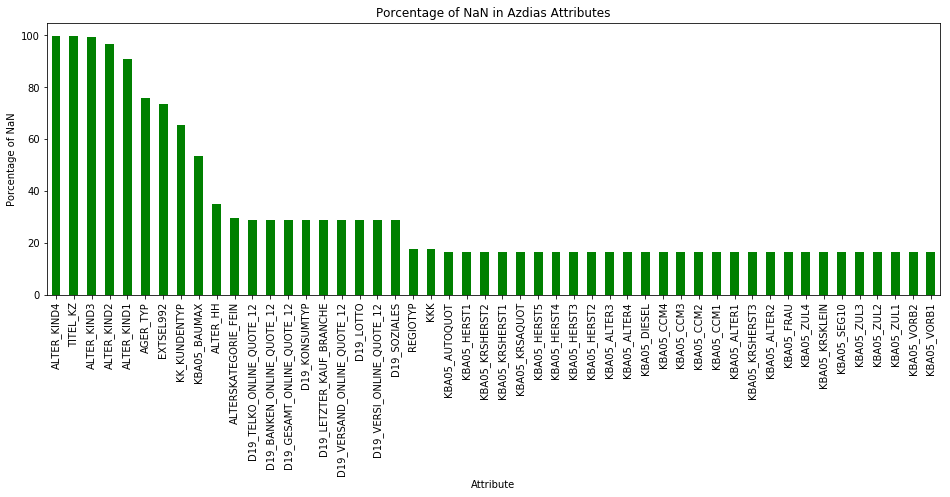

In [33]:
# how much missing data there is in each column of the dataset.

# NaN participation by column
percent_column_az = azdias.isnull().mean() * 100
percent_column_df_az = pd.DataFrame({'Attribute': azdias.columns, 'percent_nan':percent_column_az})
percent_column_df_az.sort_values('percent_nan', ascending=False, inplace=True)
percent_column_df_az[:50].plot(x='Attribute', y='percent_nan', kind='bar', legend=False, color='green')

# Get plot  
plt.title("Porcentage of NaN in Azdias Attributes")
plt.xlabel("Attribute")
plt.ylabel("Porcentage of NaN")
fig = plt.gcf()
fig.set_size_inches(16, 5);

I´m thinking drop columns with more than 60% of nulls, How many attributes are?

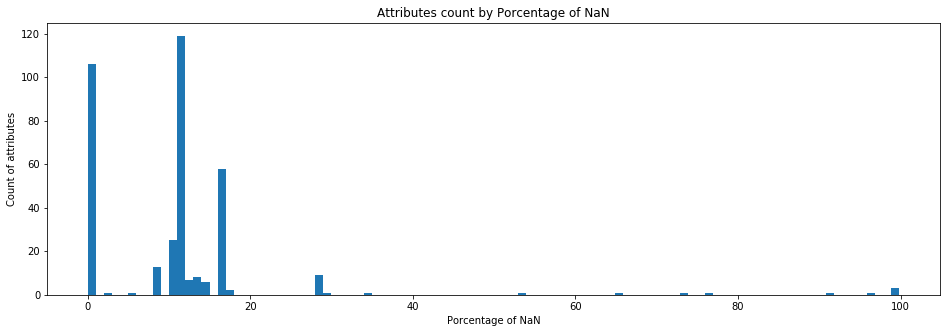

In [34]:
plt.hist(percent_column_az, bins = 100)
plt.title("Attributes count by Porcentage of NaN")
plt.xlabel("Porcentage of NaN")
plt.ylabel("Count of attributes")
fig = plt.gcf()
fig.set_size_inches(16, 5);

The impact of dropping columns in azdias dataframe with null percentages above 20% is low

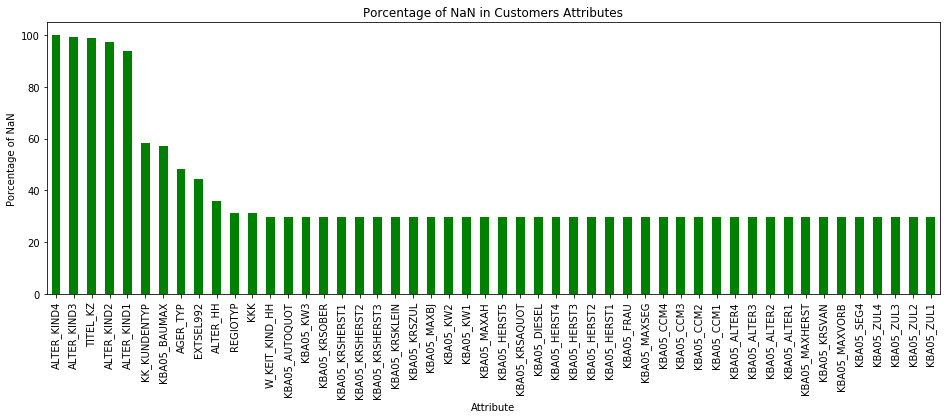

In [35]:
# what about customers dataframe?
# how much missing data there is in each column of the dataset.

# NaN participation by column
percent_column_cust = customers.isnull().mean() * 100
percent_column_df_cust = pd.DataFrame({'Attribute': customers.columns, 'percent_nan':percent_column_cust})
percent_column_df_cust.sort_values('percent_nan', ascending=False, inplace=True)
percent_column_df_cust[:50].plot(x='Attribute', y='percent_nan', kind='bar', legend=False, color='green')

# Get plot  
plt.title("Porcentage of NaN in Customers Attributes")
plt.xlabel("Attribute")
plt.ylabel("Porcentage of NaN")
fig = plt.gcf()
fig.set_size_inches(16, 5);

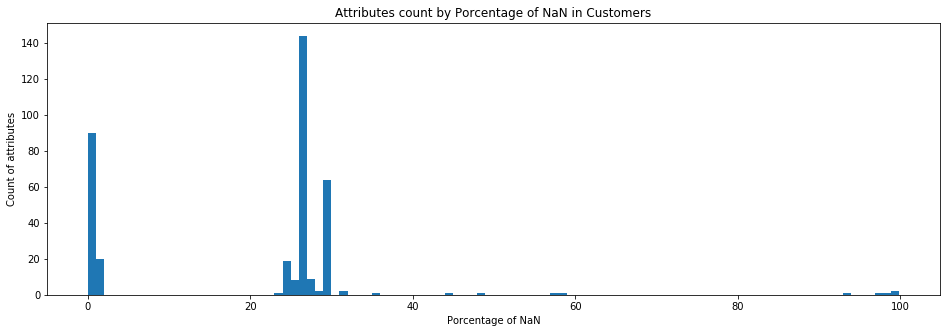

In [36]:
plt.hist(percent_column_cust, bins = 100)
plt.title("Attributes count by Porcentage of NaN in Customers")
plt.xlabel("Porcentage of NaN")
plt.ylabel("Count of attributes")
fig = plt.gcf()
fig.set_size_inches(16, 5);

At first I thought that with 20% null on the attributes, it was low seeing only the azdias dataframe. However, when we see the customers dataframe, the scenario changes a bit, since if we applied the same principle of eliminating columns with 20% we would be eliminating most of the columns. With the above, so that both dataframes have the same rule, I consider removing the columns that are in customers dataframe with more than 30% null. Why customers dataframe¡ because it has more attrributes than azdias dataframe.

In [37]:
# Get a list of attributtes names to drop
attrb_to_drop = percent_column_cust[percent_column_cust > 30].index
attrb_to_drop

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'KKK',
       'REGIOTYP', 'TITEL_KZ'],
      dtype='object')

In [38]:
# Drop attributes for each dataframe
# AZDIAS Dataframe
azdias.drop(labels = attrb_to_drop, axis = 1, inplace = True)

# CUSTOMERS Dataframe
customers.drop(labels = attrb_to_drop, axis = 1, inplace = True)

# Validate shapes
print("azdias dataframe has:", azdias.shape[0], "rows, and:", azdias.shape[1], "columns")
print("azdias dataframe has:", customers.shape[0], "rows, and:", customers.shape[1], "columns")

azdias dataframe has: 891221 rows, and: 354 columns
azdias dataframe has: 191652 rows, and: 357 columns


#### Missing values by rows

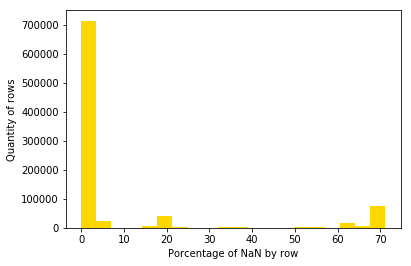

In [39]:
# How much data is missing in each row of the dataset?

# NaN participation by row
miss_row_az = azdias.isnull().mean(axis=1) * 100

# plot count missing data by rows
miss_row_az.plot(kind="hist", bins = 20, fig=(30,15), color='gold')

# Get plot  
# plt.title("Quantity of rows by Porcentage of NaN in Azdias Attributes")
plt.ylabel("Quantity of rows")
plt.xlabel("Porcentage of NaN by row");

Text(0.5,0,'Porcentage of NaN by row')

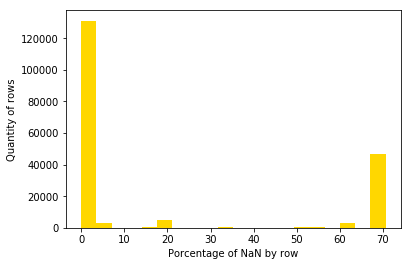

In [40]:
# How much data is missing in each row of the dataset?

# NaN participation by row
miss_row_cust = customers.isnull().mean(axis=1) * 100

# plot count missing data by rows
miss_row_cust.plot(kind="hist", bins = 20, fig=(30,15), color='gold')

# Get plot  
# plt.title("Quantity of rows by Porcentage of NaN in Azdias Attributes")
plt.ylabel("Quantity of rows")
plt.xlabel("Porcentage of NaN by row")

Unlike the analysis of NaN per column, here both dataframes have a similar behavior, so it will be easier to determine the minimum participation limit of NaN per record, being in this case 10%.

In [41]:
# Drop rows for each dataframe
# AZDIAS Dataframe
azdias = azdias[miss_row_az <= 10].reset_index(drop = True)

# CUSTOMERS Dataframe
customers = customers[miss_row_cust <= 10].reset_index(drop = True)

# Validate shapes
print("azdias dataframe has:", azdias.shape[0], "rows, and:", azdias.shape[1], "columns")
print("azdias dataframe has:", customers.shape[0], "rows, and:", customers.shape[1], "columns")

azdias dataframe has: 737215 rows, and: 354 columns
azdias dataframe has: 134244 rows, and: 357 columns


#### Drop columns

We eliminate those attributes that, despite being in our two dataframes azdias and customers, are not in our dictionary, that is, attributes_values dataframe. This is because I don't know what they mean and in the event of doing feature engineering I don't know how to do it, not understanding the values

In [42]:
# get the columns that are not in attribute_values dataframe

# get list of all attrbutes from my diccionary --> attributes_values dataframe
num_attrb_dicc = attributes_values.Attribute.unique().tolist()
num_attrb_dicc_uniq = set(list(num_attrb_dicc))

# get list columns to drop
cols_to_drop_2 = list((set(azdias.columns) & set(customers.columns)).difference(num_attrb_dicc_uniq))
cols_to_drop_2

['D19_DIGIT_SERV',
 'VHA',
 'MOBI_RASTER',
 'STRUKTURTYP',
 'D19_TELKO_ONLINE_QUOTE_12',
 'KBA13_ANTG2',
 'D19_LOTTO',
 'D19_BILDUNG',
 'D19_KOSMETIK',
 'D19_HAUS_DEKO',
 'D19_VERSI_OFFLINE_DATUM',
 'CJT_KATALOGNUTZER',
 'ANZ_KINDER',
 'AKT_DAT_KL',
 'D19_BEKLEIDUNG_GEH',
 'KBA13_ANTG1',
 'RT_UEBERGROESSE',
 'CAMEO_INTL_2015',
 'CJT_TYP_5',
 'FIRMENDICHTE',
 'D19_ENERGIE',
 'D19_TECHNIK',
 'VK_DISTANZ',
 'ALTERSKATEGORIE_FEIN',
 'LNR',
 'ARBEIT',
 'HH_DELTA_FLAG',
 'KOMBIALTER',
 'KBA13_KMH_210',
 'UNGLEICHENN_FLAG',
 'D19_DROGERIEARTIKEL',
 'CJT_TYP_2',
 'D19_WEIN_FEINKOST',
 'D19_BANKEN_LOKAL',
 'CJT_TYP_6',
 'CJT_TYP_1',
 'KBA13_GBZ',
 'D19_TELKO_REST',
 'D19_VERSAND_REST',
 'VERDICHTUNGSRAUM',
 'D19_HANDWERK',
 'D19_TELKO_MOBILE',
 'D19_VERSI_ONLINE_DATUM',
 'RT_KEIN_ANREIZ',
 'D19_REISEN',
 'DSL_FLAG',
 'D19_FREIZEIT',
 'D19_NAHRUNGSERGAENZUNG',
 'VHN',
 'VK_ZG11',
 'UMFELD_JUNG',
 'KBA13_BAUMAX',
 'KBA13_CCM_1401_2500',
 'D19_VOLLSORTIMENT',
 'D19_KINDERARTIKEL',
 'D19_BANKEN_DIR

In [43]:
# drop columns
azdias = azdias.drop(cols_to_drop_2, axis = 1)
customers = customers.drop(cols_to_drop_2, axis = 1)

How we are doing in terms of shapes in the three dataframes (azdias, customers and attributes_values)

In [44]:
# get list of all attrbutes from my diccionary --> attributes_values dataframe
num_attrb_dicc = attributes_values.Attribute.unique().tolist()

# get all columns or attributes from azdias dataframe
azdias_attrb = azdias.columns.values.tolist()
# get all columns or attributes from customers dataframe
costum_attrb = customers.columns.values.tolist()

# What are the attributes that both azdias and attributes_values have in common?
common_az_dicc_attr = list(set.intersection(set(azdias_attrb), set(num_attrb_dicc)))

# What are the attributes that both customers and attributes_values have in common?
common_costum_dicc_attr = list(set.intersection(set(costum_attrb), set(num_attrb_dicc)))

# What are the attributes in azdias but not in attributes_values?
diff_az_dicc_attr = list(set(azdias) - set(attributes_values["Attribute"].tolist()))

# What are the attributes in customers but not in attributes_values?
diff_costum_dicc_attr = list(set(customers) - set(attributes_values["Attribute"].tolist()))

# What are the attributes in attributes_values but not in azdias?
diff_dicc_az_attr = list(set(attributes_values["Attribute"].tolist()) - set(azdias))

# What are the attributes in attributes_values but not in customers?
diff_dicc_costum_attr = list(set(attributes_values["Attribute"].tolist()) - set(customers))

print("I have in common both azdias and attributes_values:",len(common_az_dicc_attr),"attributtes")
print("I have in common both customers and attributes_values:",len(common_costum_dicc_attr),"attributtes")
print("-----")
print("I have:",len(diff_az_dicc_attr),"attributtes are in azdias but not in attributes_values")
print("I have:",len(diff_costum_dicc_attr),"attributtes are in customers but not in attributes_values")
print("-----")
print("I have:",len(diff_dicc_az_attr),"attributtes are in attributes_values but not in azdias")
print("I have:",len(diff_dicc_costum_attr),"attributtes are in attributes_values but not in customers")

I have in common both azdias and attributes_values: 266 attributtes
I have in common both customers and attributes_values: 266 attributtes
-----
I have: 0 attributtes are in azdias but not in attributes_values
I have: 3 attributtes are in customers but not in attributes_values
-----
I have: 48 attributtes are in attributes_values but not in azdias
I have: 48 attributtes are in attributes_values but not in customers


#### Feature Engineering and Fill NaN with Imputation

This is a complex step because it is generating new variables, especially since we have more than 300 attributes. In the same way, to do everything in the same process, the imputation of the missing values is carried out.

In [45]:
col_names = list(azdias.columns)
dictionary = {}

for col in col_names:
    val_uniq = azdias[col].unique()
    dictionary[col] = len(val_uniq)
    
col_val_df = pd.DataFrame.from_dict(dictionary, orient='index', columns=['val_uniq'])
col_val_df.sort_values(by='val_uniq', ascending=False).head(20)

,val_uniq
KBA13_ANZAHL_PKW,1261
ANZ_HAUSHALTE_AKTIV,284
GEBURTSJAHR,117
CAMEO_DEU_2015,45
LP_LEBENSPHASE_FEIN,42
ANZ_PERSONEN,27
ANZ_HH_TITEL,21
MIN_GEBAEUDEJAHR,21
PRAEGENDE_JUGENDJAHRE,16
LP_LEBENSPHASE_GROB,14


In [46]:
def cat_feature_eng(df):
    '''This function handle specific columns (categorical) and imput more frequently
    to categorical attributes the other attributes with mean. 
    IMPUT: 
        df: dataframe to feature engineering
    OUTPUT: none
    '''
    # Encoder to use
    le = LabelEncoder()
    
    
             
    #CAMEO_INTL_2015 (Ranks)
    border = [0,20,30,40,50,60]
    labels = ["Affluent","High-income","Middle-income","Low-income","Poor"]
    # Only azdias dataframe
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth'] = pd.cut(df["CAMEO_INTL_2015"], border, labels = labels)
    print("process 1")

    
    # LP_LEBENSPHASE_FEIN 
    # 42 categories, with attributes_values attributes_values or dictionary, these are the categories
    family = {
        1: 'single', 2: 'single', 3: 'single', 4: 'single', 5: 'single', 6: 'single', 7: 'single',
        8: 'single', 9: 'single', 10:'single', 11:'single', 12:'single', 13:'single', 14:'couples',
        15:'couples', 16:'couples', 17:'couples', 18:'couples', 19:'couples', 20:'couples', 21:'single_parent',
        22:'single_parent', 23:'single_parent', 24:'families', 25:'families', 26:'families', 27:'families', 28:'families',
        29:'mulitperson_households', 30:'mulitperson_households', 31:'mulitperson_households', 32:'mulitperson_households',
        33:'mulitperson_households', 34:'mulitperson_households', 35:'mulitperson_households', 36:'mulitperson_households',
        37:'mulitperson_households', 38:'mulitperson_households', 39:'mulitperson_households', 40:'mulitperson_households'
    }
    earn = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low', 7: 'average',
        8: 'average', 9: 'independant', 10:'wealthy', 11:'homeowners', 12:'homeowners', 13:'top', 14:'low',
        15: 'low', 16:'average', 17: 'independant', 18:'wealthy', 19:'homeowners', 20:'top', 21:'low',
        22: 'average', 23:'high', 24:'low', 25:'average', 26: 'independant', 27:'homeowners', 28:'top',
        29: 'low', 30:'average', 31:'low', 32:'average',
        33: 'independant', 34:'homeowners', 35:'top', 36: 'independant',
        37: 'homeowners', 38:'homeowners', 39:'top', 40:'top'
    }
    age = {
        1: 'younger_age', 2: 'middle_age', 3: 'younger_age', 4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age', 7: 'advanced_age',
        8: 'retirement_age', 9: np.nan, 10: np.nan, 11:'advanced_age', 12:'retirement_age', 13:'higher_age', 14:'younger_age',
        15: 'higher_age', 16:'higher_age', 17: np.nan, 18:'younger_age', 19:'higher_age', 20:'higher_age', 21: np.nan,
        22: np.nan, 23:np.nan, 24:np.nan, 25:np.nan, 26: np.nan, 27:np.nan, 28:np.nan,
        29: 'younger_age', 30:'younger_age', 31:'higher_age', 32:'higher_age',
        33: 'younger_age', 34:'younger_age', 35:'younger_age', 36: 'higher_age',
        37: 'advanced_age', 38:'retirement_age', 39:'middle_age', 40:'retirement_age'
    }
    
    if 'LP_LEBENSPHASE_FEIN' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family'] = df['LP_LEBENSPHASE_FEIN'].map(family)
        df['LP_LEBENSPHASE_FEIN_earn'] = df['LP_LEBENSPHASE_FEIN'].map(earn)
        df['LP_LEBENSPHASE_FEIN_age'] = df['LP_LEBENSPHASE_FEIN'].map(age)
    print("process 2")
    
    #LP_FAMILIE_GROB
    # 11 categories, with attributes_values attributes_values or dictionary, these are the categories
    family = {
        1: 'single', 2: 'couple', 3: 'single_parent', 4: 'single_parent', 5: 'single_parent', 
        6: 'family', 7: 'family', 8: 'family', 9: 'mulitperson_households', 10: 'mulitperson_households', 
        11: 'mulitperson_households'
    }
    if 'LP_FAMILIE_GROB' in df.columns:
        df['LP_FAMILIE_GROB_family'] = df['LP_FAMILIE_GROB'].map(family)
    print("process 3")
    
    #LP_STATUS_GROB
    # 10 categories, with attributes_values attributes_values or dictionary, these are the categories
    earn = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'average', 
        6: 'independant', 7: 'independant', 8: 'houseowners', 9: 'houseowners', 10: 'top'
    }
    if 'LP_STATUS_GROB' in df.columns:
        df['LP_STATUS_GROB_earn'] = df['LP_STATUS_GROB'].map(earn)
    print("process 4")
    
    #PRAEGENDE_JUGENDJAHRE
    # 16 categories, with attributes_values attributes_values or dictionary, these are the categories
    movement = {
        1: 'mainstream', 2: 'avantgarde', 3: 'mainstream', 4: 'avantgarde',
        5: 'mainstream', 6: 'avantgarde', 7: 'avantgarde', 8: 'mainstream', 9: 'avantgarde', 
        10: 'mainstream', 11: 'avantgarde', 12: 'mainstream', 13: 'avantgarde', 14: 'mainstream',
        15: 'avantgarde'
    }
    # decade
    border_dec = [0, 2, 4, 7, 9, 13, 15]
    labels_dec = ['40s', '50s', '60s','70s','80s','90s']
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement)
        df['PRAEGENDE_JUGENDJAHRE_decade'] = pd.cut(df["PRAEGENDE_JUGENDJAHRE"], border_dec, labels = labels_dec)         
    print("process 5")
    
    # EINGEFUEGT_AM Only in azdias, convert to year
    if 'EINGEFUEGT_AM' in df.columns:
        df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year      
    print("process 6")
    
    
    # Since there are NaN, they are imputed with more frequently, since they are categorical variables    
    cat_attr = ['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth','LP_LEBENSPHASE_FEIN', 
                'LP_LEBENSPHASE_FEIN_family', 'LP_LEBENSPHASE_FEIN_earn', 
                'LP_LEBENSPHASE_FEIN_age', 'LP_FAMILIE_GROB', 'LP_FAMILIE_GROB_family', 
                'LP_STATUS_GROB', 'LP_STATUS_GROB_earn', 'PRAEGENDE_JUGENDJAHRE', 
                'PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade', 'EINGEFUEGT_AM',
                'OST_WEST_KZ', 'CAMEO_DEU_2015', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 
                'D19_LETZTER_KAUF_BRANCHE']
    
    # Fill NAN with MORE FREQUENTLY categorical attributes, the other columns with MEAN:
    for attr in df.columns:
        if attr in cat_attr:
            df[attr].fillna(df[attr].value_counts().idxmax(), inplace = True)
        else:
             df[attr].fillna(df[attr].mean(), inplace = True)
    
   
    #Get label encoding with labelencoder
    
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth'] = le.fit_transform(df['CAMEO_INTL_2015_wealth'])
    print("process 7")
    
    if 'LP_LEBENSPHASE_FEIN_family' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family'] = le.fit_transform(df['LP_LEBENSPHASE_FEIN_family'])
        df['LP_LEBENSPHASE_FEIN_earn'] = le.fit_transform(df['LP_LEBENSPHASE_FEIN_earn'])
        df['LP_LEBENSPHASE_FEIN_age'] = le.fit_transform(df['LP_LEBENSPHASE_FEIN_age'])
        df['LP_FAMILIE_GROB_family'] = le.fit_transform(df['LP_FAMILIE_GROB_family'])
        df['LP_STATUS_GROB_earn'] = le.fit_transform(df['LP_STATUS_GROB_earn'])
    print("process 8")
        
    if 'PRAEGENDE_JUGENDJAHRE_movement' in df.columns:   
        df['PRAEGENDE_JUGENDJAHRE_movement'] = le.fit_transform(df['PRAEGENDE_JUGENDJAHRE_movement'])
        df['PRAEGENDE_JUGENDJAHRE_decade'] = le.fit_transform(df['PRAEGENDE_JUGENDJAHRE_decade'])
    print("process 9")
        
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = le.fit_transform(df['OST_WEST_KZ'])
    print("process 10")

    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'] = le.fit_transform(df['CAMEO_DEU_2015'])
    print("process 11")
        
    if 'PRODUCT_GROUP' in df.columns:
        df['PRODUCT_GROUP'] = le.fit_transform(df['PRODUCT_GROUP'])      
    print("process 12")
        
    if 'CUSTOMER_GROUP' in df.columns:
        df['CUSTOMER_GROUP'] = le.fit_transform(df['CUSTOMER_GROUP'])
    print("process 13")

        
    # Drop this columns because i have new columns labeled
    drop_cols = ['CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'PRAEGENDE_JUGENDJAHRE', 
                 'D19_LETZTER_KAUF_BRANCHE']
    df.drop(drop_cols, axis = 1, inplace = True, errors='ignore') 
    print("process 14")

In [47]:
# Feature engineering both dataframes
cat_feature_eng(azdias)
cat_feature_eng(customers)

process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14


In [48]:
# At this point, i haven´t object datatype columns
print(azdias.info())
print()
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737215 entries, 0 to 737214
Columns: 269 entries, ANZ_HAUSHALTE_AKTIV to PRAEGENDE_JUGENDJAHRE_decade
dtypes: float64(212), int64(57)
memory usage: 1.5 GB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134244 entries, 0 to 134243
Columns: 272 entries, ANZ_HAUSHALTE_AKTIV to PRAEGENDE_JUGENDJAHRE_decade
dtypes: float64(212), int64(60)
memory usage: 278.6 MB
None


In [49]:
# At this point, i haven´t in all dataframe NaN
print("Number of null in azdias dataset:",azdias.isna().sum().sum())
print("Number of null in customers dataset:",customers.isna().sum().sum())

Number of null in azdias dataset: 0
Number of null in customers dataset: 0


#### Correlated Features

It is important that our variables or attributes are not correlated with each other, there are those who suggest that it should be 0.7, another 0.8 and another 0.9, as a minimum limit to eliminate correlated attributes. For this case we will implement a minimum correlation to eliminate attributes from 0.9

In [50]:
def corr_eval(df):
    """
    This function return correlated attributes of a dataframe 
    INPUT:
        df: Dtaframe to evalute correlation by attribute
    OUTPUT:
        List of attributes correlated
        
    """
    corr_mtx = df.corr().abs().round(2)
    
    corr_attrb = set()
    for i in range(len(corr_mtx.columns)):
        for j in range(i):
            # If the correlation between two attributes is greater than 0.90
            if abs(corr_mtx.iloc[i, j]) > 0.90:                
                corr_attrb.add( corr_mtx.columns[i] )
                
    return corr_attrb   

In [51]:
attribut_to_drop_corr = corr_eval(azdias)
attribut_to_drop_corr

{'CAMEO_DEUG_2015',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'KBA13_HALTER_66',
 'KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_GROB_earn',
 'PRAEGENDE_JUGENDJAHRE_movement'}

In [52]:
# Drop correlated attributes in each dataframes
azdias = azdias.drop(attribut_to_drop_corr, axis = 1)
customers = customers.drop(attribut_to_drop_corr, axis = 1)

#### Delete duplicated rows 

I will drop duplicate records in both dataframes

In [53]:
# How many duplicate records do I have in each data frame?
print("azdias dataframe has:",azdias.duplicated().sum(),"duplicated rows")
print("customers dataframe has:",customers.duplicated().sum(),"duplicated rows")

azdias dataframe has: 140 duplicated rows
customers dataframe has: 202 duplicated rows


In [54]:
# drop duplicated rows in each dataframe
azdias.drop_duplicates()
customers.drop_duplicates()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_OFFLINE_DATUM,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_STATUS_FEIN,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family,LP_LEBENSPHASE_FEIN_earn,LP_LEBENSPHASE_FEIN_age,LP_FAMILIE_GROB_family,PRAEGENDE_JUGENDJAHRE_decade
0,1.0,0.000000,2.0,0.0,3.0,0,5.0,0,0,10,10,10,0.000000,0,0,9,9,10,0.000000,3.000000,0,0,10,10,10,0,9,0,0,

In [55]:
# Validate shapes
print("azdias dataframe has:", azdias.shape[0], "rows, and:", azdias.shape[1], "columns")
print("customers dataframe has:", customers.shape[0], "rows, and:", customers.shape[1], "columns")

azdias dataframe has: 737215 rows, and: 258 columns
customers dataframe has: 134244 rows, and: 261 columns


### 0.3. Data Cleaning Function

In [37]:
def clean_data(df):
    """
    Cleaning and Pre-processing Function
    - Step 1: Get attribute_values
    - Step 2: Replace X and XX in mixed datatype attributes with NAN
    - Step 3: Replace Unknown values with NAN
    - Step 4: Handle missing values by columns
    - Step 5: Handle missing values by rows
    - Step 6: Drop attributes are in dataframe but aren´t in our dictionary (attribute_values dataframe)
    - Step 7: Feature Engineering and Impute NAN
    - Step 8: Drop correlated Features
    - Step 9: Drop duplicated rows
    
    INPUT
    - df: Dataframe to be cleanned and pre-processed
    
    OUTPUT
    - df: Dataframe cleanned and pre-processed
    """
    
    
    
    # Get attribute values
    attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
    attributes_values = attributes_values.ffill()
    
    print("step 1")
    # --------------------------------------------------------------------------------
    
    # Replace X and XX in mixed datatype attributes with NAN
    cols_repl_1 = ["CAMEO_DEU_2015"] # categorical column
    cols_repl_2 = ["CAMEO_DEUG_2015","CAMEO_INTL_2015"] # numerical columns    
    df[cols_repl_1] = df[cols_repl_1].replace({"XX":np.nan})
    df[cols_repl_2] = df[cols_repl_2].replace({"X":np.nan, "XX":np.nan})    
    df[cols_repl_1] = df[cols_repl_1].astype('object')
    df[cols_repl_2] = df[cols_repl_2].astype(float)
    
    print("step 2")
    # --------------------------------------------------------------------------------
    
    # Replace Unknown values with NAN
    # Generate a list  with the values "unknown" and "unknown / no detectable parent age"
    unknown = attributes_values[attributes_values["Meaning"].isin(["unknown", "unknown / no main age detectable"])]
    set(unknown["Meaning"].tolist())    
    for column in df.columns:            
        # Skip if the column is not in the list of unknown values
        if column not in set(unknown['Attribute']):
            continue        
        # Get the unknown value
        unknown_value = unknown.loc[unknown['Attribute'] == column].Value.item()    
        # If the value is a string, convert to int
        if type(unknown_value) is str:
            unknown_value = set(int(x) for x in unknown_value.split(', '))
        else:
            unknown_value = set([int(unknown_value)])    
        # Replace unknown values with NaN
        df[column] = df[column].mask(df[column].isin(unknown_value), other=np.nan)  
        
    print("step 3")
    # --------------------------------------------------------------------------------
    
    # Handle missing values by columns
    # I don´t apply all code (commented), because i identified in both dataframes 30% NAN
    # NaN participation by column
    #percent_column = df.isnull().mean() * 100
    #percent_column_df = pd.DataFrame({'Attribute': df.columns, 'percent_nan':percent_column})
    # Get a list of attributtes names to drop
    #attrb_to_drop = percent_column[percent_column > 30].index
    attrb_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 
                     'ALTER_KIND2', 'ALTER_KIND3',
                     'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 
                     'KK_KUNDENTYP', 'KKK',
                     'REGIOTYP', 'TITEL_KZ'] # Defined in previous analysis    
    # Drop attributes for each dataframe
    df.drop(labels = attrb_to_drop, axis = 1, inplace = True)
    
    print("step 4")
    # --------------------------------------------------------------------------------

    
    # Handle missing values by rows
    # NaN participation by row
    miss_row = df.isnull().mean(axis=1) * 100
    df = df[miss_row <= 10].reset_index(drop = True)
    
    print("step 5")
    # --------------------------------------------------------------------------------

    
    # Drop attributes are in dataframe but aren´t in our dictionary (attribute_values dataframe)
    # I don´t apply all code (commented), because different attributes to drop were identified in
    # previous analisis both dataframes and different to dictionary
    # get list of all attrbutes from my diccionary --> attributes_values dataframe
    #num_attrb_dicc = attributes_values.Attribute.unique().tolist()
    #num_attrb_dicc_uniq = set(list(num_attrb_dicc))
    # get list columns to drop    
    #cols_to_drop_2 = list((set(df.columns)).difference(num_attrb_dicc_uniq))
    cols_to_drop_2 = ['D19_KINDERARTIKEL',
                         'CJT_TYP_2',
                         'D19_BANKEN_REST',
                         'D19_SOZIALES',
                         'KBA13_BAUMAX',
                         'D19_ENERGIE',
                         'UNGLEICHENN_FLAG',
                         'D19_KONSUMTYP_MAX',
                         'D19_DROGERIEARTIKEL',
                         'ANZ_STATISTISCHE_HAUSHALTE',
                         'D19_NAHRUNGSERGAENZUNG',
                         'D19_LOTTO',
                         'EINGEZOGENAM_HH_JAHR',
                         'DSL_FLAG',
                         'UMFELD_ALT',
                         'KOMBIALTER',
                         'KONSUMZELLE',
                         'KBA13_ANTG4',
                         'KBA13_CCM_1401_2500',
                         'D19_BANKEN_DIREKT',
                         'UMFELD_JUNG',
                         'KBA13_KMH_210',
                         'VHN',
                         'D19_GARTEN',
                         'EINGEFUEGT_AM',
                         'D19_BILDUNG',
                         'MOBI_RASTER',
                         'D19_HANDWERK',
                         'D19_LEBENSMITTEL',
                         'D19_VERSAND_REST',
                         'CAMEO_INTL_2015',
                         'KBA13_ANTG2',
                         'D19_DIGIT_SERV',
                         'CJT_TYP_4',
                         'D19_VERSI_ONLINE_DATUM',
                         'D19_BIO_OEKO',
                         'KBA13_ANTG3',
                         'D19_VERSI_OFFLINE_DATUM',
                         'VHA',
                         'CJT_TYP_1',
                         'SOHO_KZ',
                         'ALTERSKATEGORIE_FEIN',
                         'CJT_TYP_6',
                         'D19_VERSI_ONLINE_QUOTE_12',
                         'AKT_DAT_KL',
                         'VK_DISTANZ',
                         'D19_KOSMETIK',
                         'KBA13_HHZ',
                         'CJT_KATALOGNUTZER',
                         'D19_BEKLEIDUNG_REST',
                         'D19_BANKEN_GROSS',
                         'D19_TECHNIK',
                         'VERDICHTUNGSRAUM',
                         'FIRMENDICHTE',
                         'VK_DHT4A',
                         'D19_TELKO_ONLINE_QUOTE_12',
                         'D19_SONSTIGE',
                         'ANZ_KINDER',
                         'D19_SAMMELARTIKEL',
                         'KBA13_GBZ',
                         'CJT_TYP_5',
                         'D19_TELKO_MOBILE',
                         'RT_KEIN_ANREIZ',
                         'D19_TELKO_REST',
                         'D19_BUCH_CD',
                         'D19_FREIZEIT',
                         'ARBEIT',
                         'RT_UEBERGROESSE',
                         'RT_SCHNAEPPCHEN',
                         'CJT_TYP_3',
                         'KBA13_ANTG1',
                         'D19_BANKEN_LOKAL',
                         'D19_VOLLSORTIMENT',
                         'D19_RATGEBER',
                         'VK_ZG11',
                         'D19_WEIN_FEINKOST',
                         'D19_VERSICHERUNGEN',
                         'D19_SCHUHE',
                         'STRUKTURTYP',
                         'D19_VERSI_DATUM',
                         'GEMEINDETYP',
                         'D19_BEKLEIDUNG_GEH',
                         'D19_TIERARTIKEL',
                         'D19_HAUS_DEKO',
                         'HH_DELTA_FLAG',
                         'D19_REISEN',
                         'D19_LETZTER_KAUF_BRANCHE',
                         'LNR'] # Defined in previous analysis
    # drop columns
    df = df.drop(cols_to_drop_2, axis = 1)
    
    print("step 6")
    # --------------------------------------------------------------------------------

    # Feature Engineering and Impute NAN
    le = LabelEncoder()     
             
    #CAMEO_INTL_2015 (Ranks)
    border = [0,20,30,40,50,60]
    labels = ["Affluent","High-income","Middle-income","Low-income","Poor"]
    # Only azdias dataframe
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth'] = pd.cut(df["CAMEO_INTL_2015"], border, labels = labels)
    print("process 1")

    
    # LP_LEBENSPHASE_FEIN 
    # 42 categories, with attributes_values attributes_values or dictionary, these are the categories
    family = {
        1: 'single', 2: 'single', 3: 'single', 4: 'single', 5: 'single', 6: 'single', 7: 'single',
        8: 'single', 9: 'single', 10:'single', 11:'single', 12:'single', 13:'single', 14:'couples',
        15:'couples', 16:'couples', 17:'couples', 18:'couples', 19:'couples', 20:'couples', 21:'single_parent',
        22:'single_parent', 23:'single_parent', 24:'families', 25:'families', 26:'families', 27:'families', 28:'families',
        29:'mulitperson_households', 30:'mulitperson_households', 31:'mulitperson_households', 32:'mulitperson_households',
        33:'mulitperson_households', 34:'mulitperson_households', 35:'mulitperson_households', 36:'mulitperson_households',
        37:'mulitperson_households', 38:'mulitperson_households', 39:'mulitperson_households', 40:'mulitperson_households'
    }
    earn = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low', 7: 'average',
        8: 'average', 9: 'independant', 10:'wealthy', 11:'homeowners', 12:'homeowners', 13:'top', 14:'low',
        15: 'low', 16:'average', 17: 'independant', 18:'wealthy', 19:'homeowners', 20:'top', 21:'low',
        22: 'average', 23:'high', 24:'low', 25:'average', 26: 'independant', 27:'homeowners', 28:'top',
        29: 'low', 30:'average', 31:'low', 32:'average',
        33: 'independant', 34:'homeowners', 35:'top', 36: 'independant',
        37: 'homeowners', 38:'homeowners', 39:'top', 40:'top'
    }
    age = {
        1: 'younger_age', 2: 'middle_age', 3: 'younger_age', 4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age', 7: 'advanced_age',
        8: 'retirement_age', 9: np.nan, 10: np.nan, 11:'advanced_age', 12:'retirement_age', 13:'higher_age', 14:'younger_age',
        15: 'higher_age', 16:'higher_age', 17: np.nan, 18:'younger_age', 19:'higher_age', 20:'higher_age', 21: np.nan,
        22: np.nan, 23:np.nan, 24:np.nan, 25:np.nan, 26: np.nan, 27:np.nan, 28:np.nan,
        29: 'younger_age', 30:'younger_age', 31:'higher_age', 32:'higher_age',
        33: 'younger_age', 34:'younger_age', 35:'younger_age', 36: 'higher_age',
        37: 'advanced_age', 38:'retirement_age', 39:'middle_age', 40:'retirement_age'
    }
    
    if 'LP_LEBENSPHASE_FEIN' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family'] = df['LP_LEBENSPHASE_FEIN'].map(family)
        df['LP_LEBENSPHASE_FEIN_earn'] = df['LP_LEBENSPHASE_FEIN'].map(earn)
        df['LP_LEBENSPHASE_FEIN_age'] = df['LP_LEBENSPHASE_FEIN'].map(age)
    print("process 2")
    
    #LP_FAMILIE_GROB
    # 11 categories, with attributes_values attributes_values or dictionary, these are the categories
    family = {
        1: 'single', 2: 'couple', 3: 'single_parent', 4: 'single_parent', 5: 'single_parent', 
        6: 'family', 7: 'family', 8: 'family', 9: 'mulitperson_households', 10: 'mulitperson_households', 
        11: 'mulitperson_households'
    }
    if 'LP_FAMILIE_GROB' in df.columns:
        df['LP_FAMILIE_GROB_family'] = df['LP_FAMILIE_GROB'].map(family)
    print("process 3")
    
    #LP_STATUS_GROB
    # 10 categories, with attributes_values attributes_values or dictionary, these are the categories
    earn = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'average', 
        6: 'independant', 7: 'independant', 8: 'houseowners', 9: 'houseowners', 10: 'top'
    }
    if 'LP_STATUS_GROB' in df.columns:
        df['LP_STATUS_GROB_earn'] = df['LP_STATUS_GROB'].map(earn)
    print("process 4")
    
    #PRAEGENDE_JUGENDJAHRE
    # 16 categories, with attributes_values attributes_values or dictionary, these are the categories
    movement = {
        1: 'mainstream', 2: 'avantgarde', 3: 'mainstream', 4: 'avantgarde',
        5: 'mainstream', 6: 'avantgarde', 7: 'avantgarde', 8: 'mainstream', 9: 'avantgarde', 
        10: 'mainstream', 11: 'avantgarde', 12: 'mainstream', 13: 'avantgarde', 14: 'mainstream',
        15: 'avantgarde'
    }
    # decade
    border_dec = [0, 2, 4, 7, 9, 13, 15]
    labels_dec = ['40s', '50s', '60s','70s','80s','90s']
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement)
        df['PRAEGENDE_JUGENDJAHRE_decade'] = pd.cut(df["PRAEGENDE_JUGENDJAHRE"], border_dec, labels = labels_dec)         
    print("process 5")
    
    # EINGEFUEGT_AM Only in azdias, convert to year
    if 'EINGEFUEGT_AM' in df.columns:
        df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year      
    print("process 6")
    
    
    # Since there are NaN, they are imputed with more frequently, since they are categorical variables    
    cat_attr = ['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth','LP_LEBENSPHASE_FEIN', 
                'LP_LEBENSPHASE_FEIN_family', 'LP_LEBENSPHASE_FEIN_earn', 
                'LP_LEBENSPHASE_FEIN_age', 'LP_FAMILIE_GROB', 'LP_FAMILIE_GROB_family', 
                'LP_STATUS_GROB', 'LP_STATUS_GROB_earn', 'PRAEGENDE_JUGENDJAHRE', 
                'PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade', 'EINGEFUEGT_AM',
                'OST_WEST_KZ', 'CAMEO_DEU_2015', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 
                'D19_LETZTER_KAUF_BRANCHE']
    
    # Fill NAN with MORE FREQUENTLY categorical attributes, the other columns with MEAN:
    for attr in df.columns:
        if attr in cat_attr:
            df[attr].fillna(df[attr].value_counts().idxmax(), inplace = True)
        else:
             df[attr].fillna(df[attr].mean(), inplace = True)
    
   
    #Get label encoding with labelencoder
    
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth'] = le.fit_transform(df['CAMEO_INTL_2015_wealth'])
    print("process 7")
    
    if 'LP_LEBENSPHASE_FEIN_family' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family'] = le.fit_transform(df['LP_LEBENSPHASE_FEIN_family'])
        df['LP_LEBENSPHASE_FEIN_earn'] = le.fit_transform(df['LP_LEBENSPHASE_FEIN_earn'])
        df['LP_LEBENSPHASE_FEIN_age'] = le.fit_transform(df['LP_LEBENSPHASE_FEIN_age'])
        df['LP_FAMILIE_GROB_family'] = le.fit_transform(df['LP_FAMILIE_GROB_family'])
        df['LP_STATUS_GROB_earn'] = le.fit_transform(df['LP_STATUS_GROB_earn'])
    print("process 8")
        
    if 'PRAEGENDE_JUGENDJAHRE_movement' in df.columns:   
        df['PRAEGENDE_JUGENDJAHRE_movement'] = le.fit_transform(df['PRAEGENDE_JUGENDJAHRE_movement'])
        df['PRAEGENDE_JUGENDJAHRE_decade'] = le.fit_transform(df['PRAEGENDE_JUGENDJAHRE_decade'])
    print("process 9")
        
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = le.fit_transform(df['OST_WEST_KZ'])
    print("process 10")

    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'] = le.fit_transform(df['CAMEO_DEU_2015'])
    print("process 11")
        
    if 'PRODUCT_GROUP' in df.columns:
        df['PRODUCT_GROUP'] = le.fit_transform(df['PRODUCT_GROUP'])      
    print("process 12")
        
    if 'CUSTOMER_GROUP' in df.columns:
        df['CUSTOMER_GROUP'] = le.fit_transform(df['CUSTOMER_GROUP'])
    print("process 13")

        
    # Drop this columns because i have new columns labeled
    drop_cols = ['CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'PRAEGENDE_JUGENDJAHRE', 
                 'D19_LETZTER_KAUF_BRANCHE']
    df.drop(drop_cols, axis = 1, inplace = True, errors='ignore') 
    print("process 14")
    
    print("step 7")
    # --------------------------------------------------------------------------------

    # Drop correlated Features
    # I don´t apply all code(commented), because correlated attributes to drop were identified in
    # previous analisis
    #corr_mtx = df.corr().abs().round(2)    
    #corr_attrb = set()
    #for i in range(len(corr_mtx.columns)):
    #    for j in range(i):
    #        # If the correlation between two attributes is greater than 0.90
    #        if abs(corr_mtx.iloc[i, j]) > 0.90:                
    #            corr_attrb.add( corr_mtx.columns[i] ) 
    corr_attrb = ['CAMEO_DEUG_2015',
                     'D19_VERSAND_ANZ_24',
                     'D19_VERSAND_DATUM',
                     'D19_VERSAND_ONLINE_DATUM',
                     'D19_VERSAND_ONLINE_QUOTE_12',
                     'KBA13_HALTER_66',
                     'KBA13_HERST_SONST',
                     'KBA13_KMH_250',
                     'LP_LEBENSPHASE_GROB',
                     'LP_STATUS_GROB_earn',
                     'PRAEGENDE_JUGENDJAHRE_movement'] # Defined in previous analysis         
    # Drop correlated attributes in each dataframes
    df = df.drop(corr_attrb, axis = 1)
    
    print("step 8")
    # --------------------------------------------------------------------------------
           
    # Drop duplicated rows
    df.drop_duplicates()
    
    print("step 9")
    # --------------------------------------------------------------------------------
    
    
    return df

In [57]:
%%time
# test azdias with clean data function
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
azdias = clean_data(azdias)

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


step 1
step 2
step 3
step 4
step 5
step 6
process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
step 7
step 8
step 9
CPU times: user 1min 14s, sys: 47.3 s, total: 2min 2s
Wall time: 11min 35s


In [58]:
# Validate shapes
print("azdias dataframe has:", azdias.shape[0], "rows, and:", azdias.shape[1], "columns")

azdias dataframe has: 737215 rows, and: 258 columns


In [59]:
%%time
# test azdias with clean data function
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
customers = clean_data(customers)

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


step 1
step 2
step 3
step 4
step 5
step 6
process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
step 7
step 8
step 9
CPU times: user 14.3 s, sys: 2.08 s, total: 16.4 s
Wall time: 49.3 s


In [60]:
# Validate shapes
print("customers dataframe has:", customers.shape[0], "rows, and:", customers.shape[1], "columns")

customers dataframe has: 134244 rows, and: 261 columns


##### Comments about the clean_data function:
1. About the following steps:
     - Step 4: Handle missing values by columns
     - Step 6: Drop attributes are in dataframe but aren't in our dictionary (attribute_values dataframe)
     - Step 8: Drop correlated Features
   
   There you will see a lot of commented code and this is because in these steps there is column removal. These columns do not
   they would come out the same as if you ran the code because the columns to remove at each step were obtained by parsing
   the two dataframes, that is, CUSTOMERS and AZDIAS. While executing the lines of code as the function idea
   is that it cleans CUSTOMERS and AZDIAS separately, obtaining the columns to eliminate will not matter in each case.
   Due to the above, it is that given that previous analysis, it is that I list the columns to be eliminated so 
   that it is the same in both dataframes.
2. Applying the clean_data function is validated that it gives the same result as what I got in the previous analysis.
   Proof of this are the cells before this cell, giving the same number of columns and rows in both dataframes.
3. As an improvement, I think that in the analysis I could have included a phase of analysis of OUTLIERS, for now I did not manipulate them

### 0.4 Feature Scaling

In [38]:
# Feature Scaling with MinMaxScaler. 
def feat_scaler(df):
    """
    Function to scale dataframes
    INPUT:
    df: Dataframe to scale with MinMaxScaler
    OUTPUT:
    df_scaled: Dataframe scaled with MinMaxScaler
    """
    
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
    return df_scaled   

In [62]:
# Apply scaler function azdias dataframe
azdias_scaled = feat_scaler(azdias)
azdias_scaled.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_OFFLINE_DATUM,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_STATUS_FEIN,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family,LP_LEBENSPHASE_FEIN_earn,LP_LEBENSPHASE_FEIN_age,LP_FAMILIE_GROB_family,PRAEGENDE_JUGENDJAHRE_decade
0,0.020522,0.0,0.052632,0.0,0.833333,0.813953,0.8,0.0,0.000000,1.000000,1.0,1.000000,0.06947,0.000000,0.000000,1.000000,1.000000,1.000000,0.349539,0.5

In [63]:
# Apply scaler function customers dataframe
customers_scaled = feat_scaler(customers)
customers_scaled.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_OFFLINE_DATUM,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_STATUS_FEIN,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family,LP_LEBENSPHASE_FEIN_earn,LP_LEBENSPHASE_FEIN_age,LP_FAMILIE_GROB_family,PRAEGENDE_JUGENDJAHRE_decade
0,0.001912,0.000000,0.095238,0.0,0.333333,0.000000,0.8,0.000000,0.000000,1.000000,1.0,1.000000,0.0,0.0,0.

#### Save scaled dataframes

In [64]:
# To get a check point or recovery point I save part 0 here in csv files to both dataframe
# Remember, these dataframes are already clean
azdias_scaled.to_csv('azdias_scaled.csv', index = False, sep = ";")
customers_scaled.to_csv('customers_scaled.csv', index = False, sep = ";")

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### 1.0 Load data

In case of any problem with the work data, it is the reason why they are saved at the end of Part 0. And why in such a case, the files would be loaded again here to be able to carry out Part 1. If there was no problem with the data, don´t uncomment this cell, and continue with the next step 1.1.. Dimensionality Reduction with PCA.

In [65]:
# Load Scaled and Cleaned azdias dataframe
#azdias_scaled = pd.read_csv('azdias_scaled.csv')

In [66]:
# Load Scaled and Cleaned customers dataframe
#customers_scaled = pd.read_csv('azdias_scaled.csv')

#### 1.1. Reduction Dimensionality - PCA

Because we have a large number of columns, so that our models are not affected by this aspect, we use dimension reduction using Principal Components Analysis or PCA. In essence, what it does is generate equations where they involve or represent our real variables.To know the number of components, we use the cumulative explained variability

This code performs dimensionality reduction using the PCA (Principal Component Analysis) method. The objective of this method is to understand the main components that describe the data and eliminate those that do not provide relevant information.
The parameter "n_components" indicates the number of main components that you want to keep. If this parameter is None, then the number of principal components that explain at least 95% of the variance in the data will be retained.
The random_state parameter is a seed for the random number generator in the PCA algorithm. This allows the results to be reproducible.
The "fit" method calculates the principal components from the data. 
The "transform" method applies the transformation to the data.

In [67]:
azdias_scaled.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_OFFLINE_DATUM,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_STATUS_FEIN,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family,LP_LEBENSPHASE_FEIN_earn,LP_LEBENSPHASE_FEIN_age,LP_FAMILIE_GROB_family,PRAEGENDE_JUGENDJAHRE_decade
0,0.020522,0.0,0.052632,0.0,0.833333,0.813953,0.8,0.0,0.000000,1.000000,1.0,1.000000,0.06947,0.000000,0.000000,1.000000,1.000000,1.000000,0.349539,0.5

In [68]:
def pca_perform (data, n_components = None):
    """
    This function performs dimensionality reduction using PCA
    INPUT:
    data: dataframe to transform 
    OUTPUT:
    pca: get pca values after fitting the data
    data_transformed: get data transformed with new number of components
    """
    pca = PCA(n_components, random_state = SEED)
    pca.fit(data)
    data_transformed = pca.transform(data)
    return pca, data_transformed

In [69]:
# Get Variance for each principal component
def screen_plot(pca):
    """
    Creates a screen plot associated with the principal components
    
    INPUT:
    pca: the result of instantian of PCA in scikit learn
    OUTPUT:
    None
    """
    plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.grid(b = True)
    
    screen_plot(pca)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

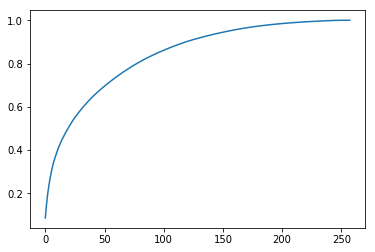

In [70]:
%%time
# Get results to AZDIAS
pca_az, data_tranf_az = pca_perform(azdias_scaled)
screen_plot(pca_az)

In [71]:
cum_variance = pd.DataFrame(np.cumsum(pca_az.explained_variance_ratio_), columns = ["cumulative_variance"])
cum_variance.set_index(cum_variance.index+1, inplace=True)
num_components = cum_variance[cum_variance["cumulative_variance"]> .90].index[0]
print(num_components," components explain 90% of variance in the AZDIAS dataset")

120  components explain 90% of variance in the AZDIAS dataset


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

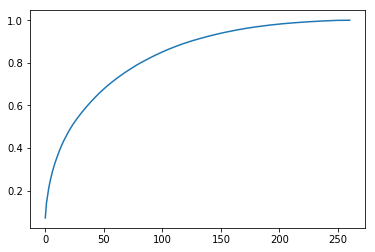

In [72]:
%%time
# Get results to CUSTOMERS
pca_cust, data_tranf_cust = pca_perform(customers_scaled)
screen_plot(pca_cust)

In [73]:
cum_variance = pd.DataFrame(np.cumsum(pca_az.explained_variance_ratio_), columns = ["cumulative_variance"])
cum_variance.set_index(cum_variance.index+1, inplace=True)
num_components = cum_variance[cum_variance["cumulative_variance"]> .90].index[0]
print(num_components," components explain 90% of variance in the CUSTOMERS dataset")

120  components explain 90% of variance in the CUSTOMERS dataset


From graph I can see with 120 components I can cover 90% of data.

To choose the number of principal components with the plot, find the point where the explained variance reaches a level that I consider acceptable. Generally, an explained variance of 85% or higher is acceptable. If the explained variance is less than 85%, then you can consider increasing the number of principal components to see if this improves the explained variance. When I see both plots with _____ compoments explain 90% of the variance

In [74]:
%%time
# Get new dataframes with reduce principal components
# AZDIAS Dataframes
pca_az_120, data_tranf_az_120 = pca_perform(azdias_scaled, 120)

CPU times: user 1min 55s, sys: 32 s, total: 2min 27s
Wall time: 6min 14s


In [75]:
%%time
# CUSTOMERS Dataframes
pca_cust_120, data_tranf_cust_120 = pca_perform(customers_scaled, 120)

CPU times: user 17.9 s, sys: 1.67 s, total: 19.5 s
Wall time: 46.6 s


#### 1.2. Clustering

In [76]:
def model_kmeans (pca, k_init, k_finish, steps):
    """
    Function to get kmeans results and plot elbow merthod
    INPUT:
    pca: array of transformed data
    k_init: min number of k clusters
    k_finish: max number of k clusters
    step: step or incremental cluster
    
    OUTPUT:
    scores: list of scores for each cluster
    """
    # get scores by cluster
    scores = []
    for i in range(k_init, k_finish, steps):
        kmeans = KMeans(n_clusters = i, random_state = 42)
        model = kmeans.fit(pca)
        score = np.abs(model.score(pca))
        scores.append(score)
        # Silloutte maybe here
     
    #Get elbow graph
    plt.plot(range(k_init, k_finish, steps),
            scores,
            marker = 'x', color='green')
    plt.xlabel("K clusters")
    plt.ylabel("Sum of squared errors")
    plt.title("Elbow Method")
    
    return scores          

CPU times: user 50min 21s, sys: 1min 30s, total: 51min 51s
Wall time: 52min 38s


[13705742.246373627,
 12343996.679184576,
 11810817.249502171,
 11438396.744740058,
 11191311.07189713,
 11006988.02751248,
 10867902.702281652,
 10745502.831089027,
 10650811.779885098,
 10571150.100213718]

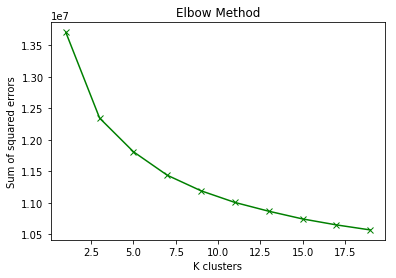

In [77]:
%%time
# Use model_kmeans function to get scores by cluster and elbow graph method
model_kmeans(data_tranf_az_120 ,1 , 20, 2)

#### KMeans with Optimal number of clusters

For this case, I could have included in the selection of the optimal cluster the Silhoutte index that combines two important metrics, both cohesion and separability, and allows me to see within a range, if the number of clusters is adequate. For now I will base myself on the previous graph where it is more visual, which is where there is a change in slope in each line (point to point). It is with the above, that given the elbow method, I consider that **8 clusters** is the correct amount with these data.

In [78]:
def opt_kmeans(data):
    """
    With optimal clusters quantity, execute Kmeans model here
    INPUT
    data: dataframe to get clusters
    OUTPUT:
    model: kmeans model
    km: get cluster labels
    """
    model = KMeans(n_clusters = 8)
    km = model.fit_predict(data)
    
    return model, km

In [79]:
# Apply opt_kmeans with k = 8 clusters to both dataframes AZDIAS and CUSTOMERS 
# km --> cluster labels
az_pca_model, az_pca_predict = opt_kmeans(data_tranf_az_120)
cust_pca_model, cust_pca_predict = opt_kmeans(data_tranf_cust_120)

# Convert to series labels
az_pca_predict = pd.Series(az_pca_predict, name = "Cluster_Azdias")
cust_pca_predict = pd.Series(cust_pca_predict, name = "Cluster_Customers")

In [82]:
# How many clients are there for each cluster in both dataframe. And Participation for each dataframe and each cluster
cluster_qty = pd.DataFrame([])

cluster_qty["Population"] = az_pca_predict.value_counts().sort_index()
cluster_qty["Customers"] = cust_pca_predict.value_counts().sort_index()

cluster_qty['% Population'] = round((cluster_qty['Population'] * 100 / cluster_qty['Population'].sum()),0)
cluster_qty['% Customers'] = round((cluster_qty['Customers'] * 100 / cluster_qty['Customers'].sum()),0)

cluster_qty.reset_index(inplace = True)
cluster_qty.rename(columns = {'index' : 'Cluster'}, inplace = True)
cluster_qty

,Cluster,Population,Customers,% Population,% Customers
0,0,123045,19464,17.0,14.0
1,1,54138,20951,7.0,16.0
2,2,107072,15325,15.0,11.0
3,3,111239,15153,15.0,11.0
4,4,90326,13241,12.0,10.0
5,5,76101,17035,10.0,13.0
6,6,116063,14409,16.0,11.0
7,7,59231,18666,8.0,14.0


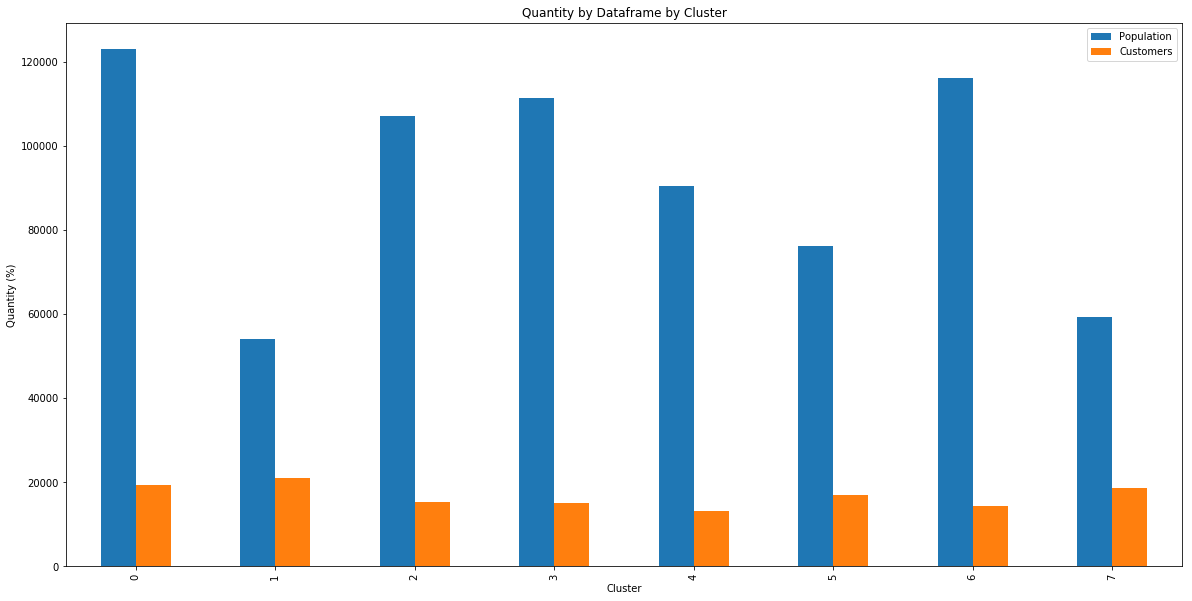

In [83]:
# Compare quantities of Population (AZDIAS) and Customers (CUSTOMERS)
cluster_qty.plot(x = 'Cluster', y = ['Population', 'Customers'], figsize=(20,10), kind = 'bar')
plt.xlabel('Cluster')
plt.ylabel('Quantity (%)')
plt.title('Quantity by Dataframe by Cluster')
plt.show();

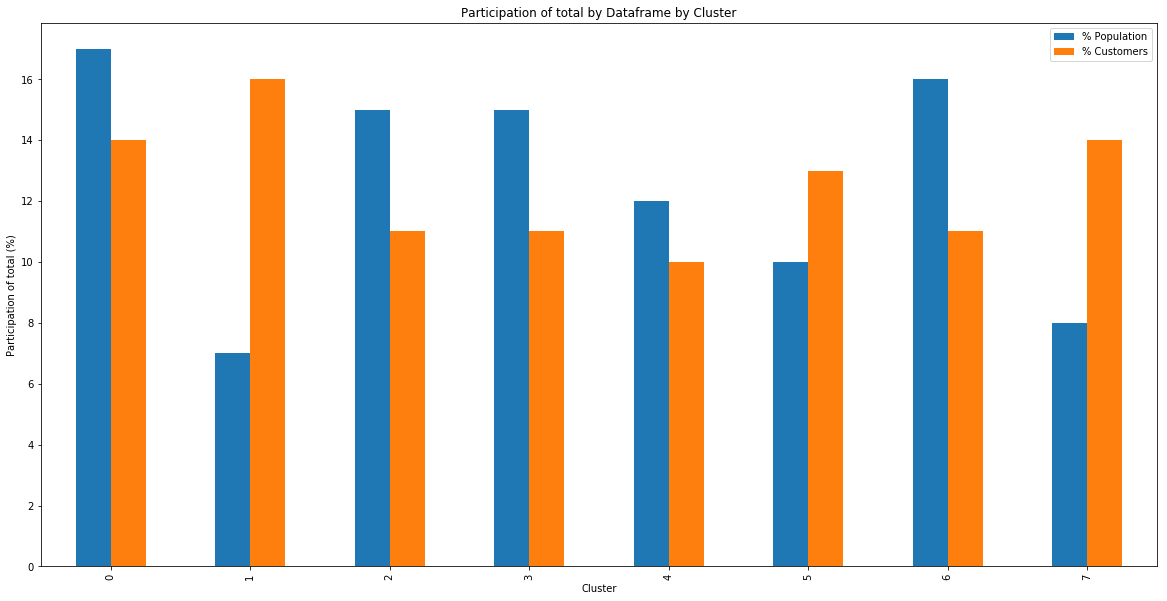

In [84]:
# Compare participations of Population (AZDIAS) and Customers (CUSTOMERS)
cluster_qty.plot(x = 'Cluster', y = ['% Population', '% Customers'], figsize=(20,10), kind = 'bar')
plt.xlabel('Cluster')
plt.ylabel('Participation of total (%)')
plt.title('Participation of total by Dataframe by Cluster')
plt.show();

Based on the latest graphs, we can see that with the company's customers where there is more participation, it is the focus on which we must concentrate, since they add up to the first 4 groups 57% that are reflected in the cluster 1 , 0 , 7 and 5 (Ordered). So by being clear about those clusters where the most customers are, it is likewise where we must look for potential customers from the population of Germany. That means, that under the premise of looking for clients from those same clusters, they are summarized in potential clients:
* Cluster 0 there are 123.045 people
* Cluster 1 there are 54.138 people
* Cluster 5 there are 76.101 people
* Cluster 7 there are 59.231 people

Approximately **312k potential** people for the business

In the same way, to avoid reaching the wrong clients with offers or perhaps they were not the first to receive the company's first offer, they are the ones in the clusters with the least participation, which means that transposing it to the population of Germany , these customers who are less likely to be part of the company are:
* Cluster 3 there are 111.239 people
* Cluster 4 there are 90.326 people

Approximately **200k people who do not represent an opportunity** for the business

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

CAMILO NOTE:
If I don't want to run the whole notebook but only this part, I just have to run the first cell (import libraries), then run the cell where the data_cleaning function is, then run the scaling function feat_scaler. Already with these three cells executed, if we execute all part 2.

### 2.0 Cleaning and Pre-processing 

In [92]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [93]:
# I will check fastly shape and other information about this new dataframe.
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [94]:
# What is the shape of mailout_train
mailout_train.shape

(42962, 367)

In [95]:
# does this dataset have null values?
print("Number of null in mailout_train dataset:",mailout_train.isna().sum().sum())

Number of null in mailout_train dataset: 2217179


#### Handle Imbalance RESPONSE Column
In my case, I make the decision to balance the data, since there is a large imbalance towards category 0.

0    42430
1      532
Name: RESPONSE, dtype: int64



<Container object of 2 artists>

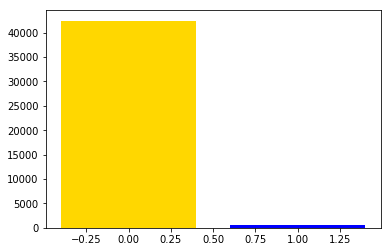

In [96]:
# Balanced or Imbalanced RESPONSE column?
print(mailout_train.RESPONSE.value_counts())
print()
plt.bar(mailout_train['RESPONSE'].unique(), mailout_train['RESPONSE'].value_counts(), color=['gold', 'blue'])

In [97]:
cust_0 = mailout_train[mailout_train["RESPONSE"] == 0] 
cust_1 = mailout_train[mailout_train["RESPONSE"] == 1] # Imbalanced

In [98]:
# Balance label == 1
cust_1_bld = resample(cust_1, replace = True, n_samples = 42430, random_state = 42)

In [99]:
# Combine cust_1 balanced with cust_0
mailout_train = pd.concat([cust_0, cust_1_bld])
print(mailout_train.RESPONSE.value_counts())

1    42430
0    42430
Name: RESPONSE, dtype: int64


#### Clean and preprocessing dataframe

In [100]:
%%time
# I will clean an preprocessing mailout_train with my clean_data function, applied in part 0 and part 1.
mailout_train = clean_data(mailout_train)

step 1
step 2
step 3
step 4
step 5
step 6
process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
step 7
step 8
step 9
CPU times: user 3.16 s, sys: 1.52 s, total: 4.68 s
Wall time: 4.8 s


#### Feature Scaling

In [101]:
# Apply scaler function mailout_train dataframe
mailout_train_scaled = feat_scaler(mailout_train)
mailout_train_scaled.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,...,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family,LP_LEBENSPHASE_FEIN_earn,LP_LEBENSPHASE_FEIN_age,LP_FAMILIE_GROB_family,PRAEGENDE_JUGENDJAHRE_decade
0,0.034247,0.000000,0.041667,0.0,0.666667,0.488372,0.2,0.000000,0.000000,1.000000,...,0.285714,0.4,0.0,1.0,0.375,0.75,0.000000,0.75,0.5,0.0
1,0.002283,0.000000,0.083333,0.0,0.666667,0.441860,0.2,0.166667,0.166667,0.444444,...,0.857143,0.0,0.0,1.0,0.250,0.00,0.333333,0.25,0.0,0.6
2,0.000000,0.002958,0.000000,0.0,0.000000,0.186047,0.6,0.000000,0.166667,0.666667,...,0.142857,0.4,0.0,0.0,0.375,0.75,0.833333,0.25,1.0,0.0
3,0.009132,0.000000,0.083333,0.0,0.166667,0.186047,0.2,0.000000,0.000000,1.000000,...,0.000000,0.4,0.0,1.0,0.375,0.00,0.000000,0.25,0.0,0.0
4,0.121005,0.000000,0.041667,0.0,0.500000,0.720930,1.0,0.000000,0.000000,1.000000,...,0.285714,0.4,0.0,0.0,0.250,0.75,0.500000,0.25,0.5,0.2


In [102]:
# Validate shapes
print("mailout_train_scaled dataframe has:", mailout_train_scaled.shape[0], "rows, and:", mailout_train_scaled.shape[1], "columns")

mailout_train_scaled dataframe has: 66548 rows, and: 259 columns


#### Save Train Scaled DataFrame

In [103]:
# To get a check point or recovery point I save part 2 here in csv file
# Remember, this dataframe are already clean
mailout_train_scaled.to_csv('mailout_train_scaled.csv', index = False, sep = ";")

### 2.1 Model Training

#### Metric Selection

Since we already have our clean, pre-processed and scaled data, we must now carry out the Modeling phase. But before that, since we must choose the best model that is capable of predicting whether an individual will become a customer or not, it is necessary to evaluate it and based on this, the one with the best evaluation would be selected. And how do we evaluate it? Machine learning models have evaluation metrics, in the specific case of classification models we find metrics such as accuracy, precision and recall. However, if we were predicting, for example, a patient whether or not he has cancer, precision would be selected because where it is serious where a client who had cancer but the model says no, the impact is serious by not treating someone who did need it. that is, the True Positives (TP). So Precision TP/(TP+FP) would be helping me determine how accurate our results are in predicting whether or not a client will have cancer. For this case, I have decided to use the AUC-ROC curves since they consider the true positive rate (TPR) and the false positive rate (FPR). As such, there is no minimum to determine from more than one model, which is the best, but simply the one with the highest score, although there are those who recommend a minimum of 0.8, but in my case, I will be interested in the one with the best score.


The evaluation metric we will use is AUC for the ROC curve. A receiver operating characteristic (ROC) curve is a graphical plot used to show the true positive rate (TPR, known as recall, the proportion of real customers correctly labeled) versus the false positive rate (FPR, proportion of not customers tagged as customers) .

#### Model Implementation

In [104]:
# divide label or objective attribute (y) and predictors or attributes (X)
y = mailout_train_scaled.RESPONSE
mailout_train_scaled.drop(labels = ['RESPONSE'], axis = 1, inplace = True)

In [106]:
def clasf_model (model, param_grid, X_train = mailout_train_scaled, y_train = y):
    """
    Train model with data and get roc score
    
    INPUT:
    model: model classifier
    param_grid: model parameters (I will use in hyperparameter tuning or GridSearchCV)
    X: predictors or attributes
    y: output or label
    
    OUTPUT: 
    model: fitted model
    roc: roc score
    """
    
    start = time.time()
    # GridSearchCV include cross validation = 5
    grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'roc_auc', cv = 5) 
    grid.fit(X_train, y_train)
    end = time.time()
    
    print("Fit Execution Time:", end-start)
    print("ROC score:", grid.best_score_)
    
    return grid.best_estimator_
    

In [107]:
# Random Forest Classifier
RFC = RandomForestClassifier(random_state = 42)
clasf_model(RFC, {})

Fit Execution Time: 23.740022659301758
ROC score: 1.0


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [108]:
# Gradient Boosting Classifier
GBC = GradientBoostingClassifier(random_state = 42)
clasf_model(GBC, {})

Fit Execution Time: 339.7765622138977
ROC score: 0.951935988499


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [109]:
# Ada Boost Classifier
ABC = AdaBoostClassifier(random_state = 42)
clasf_model(ABC, {})

Fit Execution Time: 140.20471930503845
ROC score: 0.769785387489


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42)

In [112]:
# logistic Regression Classifier
LR = LogisticRegression(random_state = 42)
clasf_model(LR, {})

Fit Execution Time: 119.6275155544281
ROC score: 0.785595393478


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
# XG Boost Classifier
#XBC = xgb.XGBClassifier(random_state = 42)
#clasf_model(ABC, {})

I would have liked to have run XGBoostClassifier but Jupyter didn't come with it and that meant installing it from the shell: pip install xgboost

#### Model Tuning

Once we have carried out the training with the four models, I select the **Gradient Boosting Classifier** because it is the one with the best score among the 4. Since with RandomForestClassifier it obtained 1, that means that it overfitted. As our function to perform the modeling already includes to place the hyperparameters, it is only necessary to call the function and include them. Remember that this clasf_model function cross-validates 5 groups, so we did not do the split that is usually done 70-30 or 80-20.

In [114]:
# GridSearchCV with param_grid (Hyperparameter tunning)

# Gradient Boosting Classifier with param_grid, i change max_features from None to 9
GBC = GradientBoostingClassifier(random_state = 42)
param_grid = {"learning_rate": [0.1],
              "loss": ["deviance"],
              "max_features": [9]}
best_clf_model = clasf_model(GBC, {})
best_clf_model

Fit Execution Time: 365.9749119281769
ROC score: 0.951935988499


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [115]:
# Compare tunning
print("GradientBoostingClassifier without tuning: 0.951935988499")
print("GradientBoostingClassifier with tuning: 0.951935988499")

GradientBoostingClassifier without tuning: 0.951935988499
GradientBoostingClassifier with tuning: 0.951935988499


Only change max_features parameter on GradientBoostingClassifier I did not see changes 

## 3.0 Get predictions to Test Dataset

As they said in part 0, we must generate the predictions to the TEST set so that they can be evaluated in Kaggle. To do this, we look for said dataset:

In [134]:
# Copy similar direction from TRAIN set, to adapt and get TEST set, and use dataset name from PART 2:  
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [135]:
# What is the shape of mailout_test
mailout_test.shape

(42833, 366)

In [136]:
# Since I need the LNR column, and it is a column removed in the process of the clean_data function
# I'll create a new function called clean_data_2 where unlike clean_data, it won't remove LNR
def clean_data_2(df):
    """
    Cleaning and Pre-processing Function
    - Step 1: Get attribute_values
    - Step 2: Replace X and XX in mixed datatype attributes with NAN
    - Step 3: Replace Unknown values with NAN
    - Step 4: Handle missing values by columns
    - Step 5: Handle missing values by rows
    - Step 6: Drop attributes are in dataframe but aren´t in our dictionary (attribute_values dataframe)
    - Step 7: Feature Engineering and Impute NAN
    - Step 8: Drop correlated Features
    - Step 9: Drop duplicated rows
    
    INPUT
    - df: Dataframe to be cleanned and pre-processed
    
    OUTPUT
    - df: Dataframe cleanned and pre-processed
    """
    
    
    
    # Get attribute values
    attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
    attributes_values = attributes_values.ffill()
    
    print("step 1")
    # --------------------------------------------------------------------------------
    
    # Replace X and XX in mixed datatype attributes with NAN
    cols_repl_1 = ["CAMEO_DEU_2015"] # categorical column
    cols_repl_2 = ["CAMEO_DEUG_2015","CAMEO_INTL_2015"] # numerical columns    
    df[cols_repl_1] = df[cols_repl_1].replace({"XX":np.nan})
    df[cols_repl_2] = df[cols_repl_2].replace({"X":np.nan, "XX":np.nan})    
    df[cols_repl_1] = df[cols_repl_1].astype('object')
    df[cols_repl_2] = df[cols_repl_2].astype(float)
    
    print("step 2")
    # --------------------------------------------------------------------------------
    
    # Replace Unknown values with NAN
    # Generate a list  with the values "unknown" and "unknown / no detectable parent age"
    unknown = attributes_values[attributes_values["Meaning"].isin(["unknown", "unknown / no main age detectable"])]
    set(unknown["Meaning"].tolist())    
    for column in df.columns:            
        # Skip if the column is not in the list of unknown values
        if column not in set(unknown['Attribute']):
            continue        
        # Get the unknown value
        unknown_value = unknown.loc[unknown['Attribute'] == column].Value.item()    
        # If the value is a string, convert to int
        if type(unknown_value) is str:
            unknown_value = set(int(x) for x in unknown_value.split(', '))
        else:
            unknown_value = set([int(unknown_value)])    
        # Replace unknown values with NaN
        df[column] = df[column].mask(df[column].isin(unknown_value), other=np.nan)  
        
    print("step 3")
    # --------------------------------------------------------------------------------
    
    # Handle missing values by columns
    # I don´t apply all code (commented), because i identified in both dataframes 30% NAN
    # NaN participation by column
    #percent_column = df.isnull().mean() * 100
    #percent_column_df = pd.DataFrame({'Attribute': df.columns, 'percent_nan':percent_column})
    # Get a list of attributtes names to drop
    #attrb_to_drop = percent_column[percent_column > 30].index
    attrb_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 
                     'ALTER_KIND2', 'ALTER_KIND3',
                     'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 
                     'KK_KUNDENTYP', 'KKK',
                     'REGIOTYP', 'TITEL_KZ'] # Defined in previous analysis    
    # Drop attributes for each dataframe
    df.drop(labels = attrb_to_drop, axis = 1, inplace = True)
    
    print("step 4")
    # --------------------------------------------------------------------------------

    
    # Handle missing values by rows
    # NaN participation by row
    miss_row = df.isnull().mean(axis=1) * 100
    df = df[miss_row <= 10].reset_index(drop = True)
    
    print("step 5")
    # --------------------------------------------------------------------------------

    
    # Drop attributes are in dataframe but aren´t in our dictionary (attribute_values dataframe)
    # I don´t apply all code (commented), because different attributes to drop were identified in
    # previous analisis both dataframes and different to dictionary
    # get list of all attrbutes from my diccionary --> attributes_values dataframe
    #num_attrb_dicc = attributes_values.Attribute.unique().tolist()
    #num_attrb_dicc_uniq = set(list(num_attrb_dicc))
    # get list columns to drop    
    #cols_to_drop_2 = list((set(df.columns)).difference(num_attrb_dicc_uniq))
    cols_to_drop_2 = ['D19_KINDERARTIKEL',
                         'CJT_TYP_2',
                         'D19_BANKEN_REST',
                         'D19_SOZIALES',
                         'KBA13_BAUMAX',
                         'D19_ENERGIE',
                         'UNGLEICHENN_FLAG',
                         'D19_KONSUMTYP_MAX',
                         'D19_DROGERIEARTIKEL',
                         'ANZ_STATISTISCHE_HAUSHALTE',
                         'D19_NAHRUNGSERGAENZUNG',
                         'D19_LOTTO',
                         'EINGEZOGENAM_HH_JAHR',
                         'DSL_FLAG',
                         'UMFELD_ALT',
                         'KOMBIALTER',
                         'KONSUMZELLE',
                         'KBA13_ANTG4',
                         'KBA13_CCM_1401_2500',
                         'D19_BANKEN_DIREKT',
                         'UMFELD_JUNG',
                         'KBA13_KMH_210',
                         'VHN',
                         'D19_GARTEN',
                         'EINGEFUEGT_AM',
                         'D19_BILDUNG',
                         'MOBI_RASTER',
                         'D19_HANDWERK',
                         'D19_LEBENSMITTEL',
                         'D19_VERSAND_REST',
                         'CAMEO_INTL_2015',
                         'KBA13_ANTG2',
                         'D19_DIGIT_SERV',
                         'CJT_TYP_4',
                         'D19_VERSI_ONLINE_DATUM',
                         'D19_BIO_OEKO',
                         'KBA13_ANTG3',
                         'D19_VERSI_OFFLINE_DATUM',
                         'VHA',
                         'CJT_TYP_1',
                         'SOHO_KZ',
                         'ALTERSKATEGORIE_FEIN',
                         'CJT_TYP_6',
                         'D19_VERSI_ONLINE_QUOTE_12',
                         'AKT_DAT_KL',
                         'VK_DISTANZ',
                         'D19_KOSMETIK',
                         'KBA13_HHZ',
                         'CJT_KATALOGNUTZER',
                         'D19_BEKLEIDUNG_REST',
                         'D19_BANKEN_GROSS',
                         'D19_TECHNIK',
                         'VERDICHTUNGSRAUM',
                         'FIRMENDICHTE',
                         'VK_DHT4A',
                         'D19_TELKO_ONLINE_QUOTE_12',
                         'D19_SONSTIGE',
                         'ANZ_KINDER',
                         'D19_SAMMELARTIKEL',
                         'KBA13_GBZ',
                         'CJT_TYP_5',
                         'D19_TELKO_MOBILE',
                         'RT_KEIN_ANREIZ',
                         'D19_TELKO_REST',
                         'D19_BUCH_CD',
                         'D19_FREIZEIT',
                         'ARBEIT',
                         'RT_UEBERGROESSE',
                         'RT_SCHNAEPPCHEN',
                         'CJT_TYP_3',
                         'KBA13_ANTG1',
                         'D19_BANKEN_LOKAL',
                         'D19_VOLLSORTIMENT',
                         'D19_RATGEBER',
                         'VK_ZG11',
                         'D19_WEIN_FEINKOST',
                         'D19_VERSICHERUNGEN',
                         'D19_SCHUHE',
                         'STRUKTURTYP',
                         'D19_VERSI_DATUM',
                         'GEMEINDETYP',
                         'D19_BEKLEIDUNG_GEH',
                         'D19_TIERARTIKEL',
                         'D19_HAUS_DEKO',
                         'HH_DELTA_FLAG',
                         'D19_REISEN',
                         'D19_LETZTER_KAUF_BRANCHE'
                         ] # Defined in previous analysis, but i dont delete LNR column
                           # This is the diference with clean_data function
    # drop columns
    df = df.drop(cols_to_drop_2, axis = 1)
    
    print("step 6")
    # --------------------------------------------------------------------------------

    # Feature Engineering and Impute NAN
    le = LabelEncoder()     
             
    #CAMEO_INTL_2015 (Ranks)
    border = [0,20,30,40,50,60]
    labels = ["Affluent","High-income","Middle-income","Low-income","Poor"]
    # Only azdias dataframe
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth'] = pd.cut(df["CAMEO_INTL_2015"], border, labels = labels)
    print("process 1")

    
    # LP_LEBENSPHASE_FEIN 
    # 42 categories, with attributes_values attributes_values or dictionary, these are the categories
    family = {
        1: 'single', 2: 'single', 3: 'single', 4: 'single', 5: 'single', 6: 'single', 7: 'single',
        8: 'single', 9: 'single', 10:'single', 11:'single', 12:'single', 13:'single', 14:'couples',
        15:'couples', 16:'couples', 17:'couples', 18:'couples', 19:'couples', 20:'couples', 21:'single_parent',
        22:'single_parent', 23:'single_parent', 24:'families', 25:'families', 26:'families', 27:'families', 28:'families',
        29:'mulitperson_households', 30:'mulitperson_households', 31:'mulitperson_households', 32:'mulitperson_households',
        33:'mulitperson_households', 34:'mulitperson_households', 35:'mulitperson_households', 36:'mulitperson_households',
        37:'mulitperson_households', 38:'mulitperson_households', 39:'mulitperson_households', 40:'mulitperson_households'
    }
    earn = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low', 7: 'average',
        8: 'average', 9: 'independant', 10:'wealthy', 11:'homeowners', 12:'homeowners', 13:'top', 14:'low',
        15: 'low', 16:'average', 17: 'independant', 18:'wealthy', 19:'homeowners', 20:'top', 21:'low',
        22: 'average', 23:'high', 24:'low', 25:'average', 26: 'independant', 27:'homeowners', 28:'top',
        29: 'low', 30:'average', 31:'low', 32:'average',
        33: 'independant', 34:'homeowners', 35:'top', 36: 'independant',
        37: 'homeowners', 38:'homeowners', 39:'top', 40:'top'
    }
    age = {
        1: 'younger_age', 2: 'middle_age', 3: 'younger_age', 4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age', 7: 'advanced_age',
        8: 'retirement_age', 9: np.nan, 10: np.nan, 11:'advanced_age', 12:'retirement_age', 13:'higher_age', 14:'younger_age',
        15: 'higher_age', 16:'higher_age', 17: np.nan, 18:'younger_age', 19:'higher_age', 20:'higher_age', 21: np.nan,
        22: np.nan, 23:np.nan, 24:np.nan, 25:np.nan, 26: np.nan, 27:np.nan, 28:np.nan,
        29: 'younger_age', 30:'younger_age', 31:'higher_age', 32:'higher_age',
        33: 'younger_age', 34:'younger_age', 35:'younger_age', 36: 'higher_age',
        37: 'advanced_age', 38:'retirement_age', 39:'middle_age', 40:'retirement_age'
    }
    
    if 'LP_LEBENSPHASE_FEIN' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family'] = df['LP_LEBENSPHASE_FEIN'].map(family)
        df['LP_LEBENSPHASE_FEIN_earn'] = df['LP_LEBENSPHASE_FEIN'].map(earn)
        df['LP_LEBENSPHASE_FEIN_age'] = df['LP_LEBENSPHASE_FEIN'].map(age)
    print("process 2")
    
    #LP_FAMILIE_GROB
    # 11 categories, with attributes_values attributes_values or dictionary, these are the categories
    family = {
        1: 'single', 2: 'couple', 3: 'single_parent', 4: 'single_parent', 5: 'single_parent', 
        6: 'family', 7: 'family', 8: 'family', 9: 'mulitperson_households', 10: 'mulitperson_households', 
        11: 'mulitperson_households'
    }
    if 'LP_FAMILIE_GROB' in df.columns:
        df['LP_FAMILIE_GROB_family'] = df['LP_FAMILIE_GROB'].map(family)
    print("process 3")
    
    #LP_STATUS_GROB
    # 10 categories, with attributes_values attributes_values or dictionary, these are the categories
    earn = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'average', 
        6: 'independant', 7: 'independant', 8: 'houseowners', 9: 'houseowners', 10: 'top'
    }
    if 'LP_STATUS_GROB' in df.columns:
        df['LP_STATUS_GROB_earn'] = df['LP_STATUS_GROB'].map(earn)
    print("process 4")
    
    #PRAEGENDE_JUGENDJAHRE
    # 16 categories, with attributes_values attributes_values or dictionary, these are the categories
    movement = {
        1: 'mainstream', 2: 'avantgarde', 3: 'mainstream', 4: 'avantgarde',
        5: 'mainstream', 6: 'avantgarde', 7: 'avantgarde', 8: 'mainstream', 9: 'avantgarde', 
        10: 'mainstream', 11: 'avantgarde', 12: 'mainstream', 13: 'avantgarde', 14: 'mainstream',
        15: 'avantgarde'
    }
    # decade
    border_dec = [0, 2, 4, 7, 9, 13, 15]
    labels_dec = ['40s', '50s', '60s','70s','80s','90s']
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement)
        df['PRAEGENDE_JUGENDJAHRE_decade'] = pd.cut(df["PRAEGENDE_JUGENDJAHRE"], border_dec, labels = labels_dec)         
    print("process 5")
    
    # EINGEFUEGT_AM Only in azdias, convert to year
    if 'EINGEFUEGT_AM' in df.columns:
        df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year      
    print("process 6")
    
    
    # Since there are NaN, they are imputed with more frequently, since they are categorical variables    
    cat_attr = ['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth','LP_LEBENSPHASE_FEIN', 
                'LP_LEBENSPHASE_FEIN_family', 'LP_LEBENSPHASE_FEIN_earn', 
                'LP_LEBENSPHASE_FEIN_age', 'LP_FAMILIE_GROB', 'LP_FAMILIE_GROB_family', 
                'LP_STATUS_GROB', 'LP_STATUS_GROB_earn', 'PRAEGENDE_JUGENDJAHRE', 
                'PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade', 'EINGEFUEGT_AM',
                'OST_WEST_KZ', 'CAMEO_DEU_2015', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 
                'D19_LETZTER_KAUF_BRANCHE']
    
    # Fill NAN with MORE FREQUENTLY categorical attributes, the other columns with MEAN:
    for attr in df.columns:
        if attr in cat_attr:
            df[attr].fillna(df[attr].value_counts().idxmax(), inplace = True)
        else:
             df[attr].fillna(df[attr].mean(), inplace = True)
    
   
    #Get label encoding with labelencoder
    
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth'] = le.fit_transform(df['CAMEO_INTL_2015_wealth'])
    print("process 7")
    
    if 'LP_LEBENSPHASE_FEIN_family' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family'] = le.fit_transform(df['LP_LEBENSPHASE_FEIN_family'])
        df['LP_LEBENSPHASE_FEIN_earn'] = le.fit_transform(df['LP_LEBENSPHASE_FEIN_earn'])
        df['LP_LEBENSPHASE_FEIN_age'] = le.fit_transform(df['LP_LEBENSPHASE_FEIN_age'])
        df['LP_FAMILIE_GROB_family'] = le.fit_transform(df['LP_FAMILIE_GROB_family'])
        df['LP_STATUS_GROB_earn'] = le.fit_transform(df['LP_STATUS_GROB_earn'])
    print("process 8")
        
    if 'PRAEGENDE_JUGENDJAHRE_movement' in df.columns:   
        df['PRAEGENDE_JUGENDJAHRE_movement'] = le.fit_transform(df['PRAEGENDE_JUGENDJAHRE_movement'])
        df['PRAEGENDE_JUGENDJAHRE_decade'] = le.fit_transform(df['PRAEGENDE_JUGENDJAHRE_decade'])
    print("process 9")
        
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = le.fit_transform(df['OST_WEST_KZ'])
    print("process 10")

    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'] = le.fit_transform(df['CAMEO_DEU_2015'])
    print("process 11")
        
    if 'PRODUCT_GROUP' in df.columns:
        df['PRODUCT_GROUP'] = le.fit_transform(df['PRODUCT_GROUP'])      
    print("process 12")
        
    if 'CUSTOMER_GROUP' in df.columns:
        df['CUSTOMER_GROUP'] = le.fit_transform(df['CUSTOMER_GROUP'])
    print("process 13")

        
    # Drop this columns because i have new columns labeled
    drop_cols = ['CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'PRAEGENDE_JUGENDJAHRE', 
                 'D19_LETZTER_KAUF_BRANCHE']
    df.drop(drop_cols, axis = 1, inplace = True, errors='ignore') 
    print("process 14")
    
    print("step 7")
    # --------------------------------------------------------------------------------

    # Drop correlated Features
    # I don´t apply all code(commented), because correlated attributes to drop were identified in
    # previous analisis
    #corr_mtx = df.corr().abs().round(2)    
    #corr_attrb = set()
    #for i in range(len(corr_mtx.columns)):
    #    for j in range(i):
    #        # If the correlation between two attributes is greater than 0.90
    #        if abs(corr_mtx.iloc[i, j]) > 0.90:                
    #            corr_attrb.add( corr_mtx.columns[i] ) 
    corr_attrb = ['CAMEO_DEUG_2015',
                     'D19_VERSAND_ANZ_24',
                     'D19_VERSAND_DATUM',
                     'D19_VERSAND_ONLINE_DATUM',
                     'D19_VERSAND_ONLINE_QUOTE_12',
                     'KBA13_HALTER_66',
                     'KBA13_HERST_SONST',
                     'KBA13_KMH_250',
                     'LP_LEBENSPHASE_GROB',
                     'LP_STATUS_GROB_earn',
                     'PRAEGENDE_JUGENDJAHRE_movement'] # Defined in previous analysis         
    # Drop correlated attributes in each dataframes
    df = df.drop(corr_attrb, axis = 1)
    
    print("step 8")
    # --------------------------------------------------------------------------------
           
    # Drop duplicated rows
    df.drop_duplicates()
    
    print("step 9")
    # --------------------------------------------------------------------------------
    
    
    return df

In [137]:
%%time
# Apply clean_data_2 to mailout_test dataframe
mailout_test = clean_data_2(mailout_test)

step 1
step 2
step 3
step 4
step 5
step 6
process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
step 7
step 8
step 9
CPU times: user 2.29 s, sys: 650 ms, total: 2.94 s
Wall time: 3.78 s


In [138]:
# Apply scaler function mailout_train dataframe
mailout_test_scaled = feat_scaler(mailout_test)
mailout_test_scaled.head()

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family,LP_LEBENSPHASE_FEIN_earn,LP_LEBENSPHASE_FEIN_age,LP_FAMILIE_GROB_family,PRAEGENDE_JUGENDJAHRE_decade
0,0.020273,0.005277,0.0,0.142857,0.0,0.833333,0.139535,0.8,0.0,0.000000,...,1.0,0.285714,0.4,0.0,0.375,0.00,0.833333,0.25,0.0,0.0
1,0.020460,0.052770,0.0,0.071429,0.0,1.000000,0.418605,0.0,0.0,0.000000,...,1.0,0.571429,0.4,0.0,0.375,0.75,0.666667,0.75,0.5,0.4
2,0.016904,0.005277,0.0,0.285714,0.0,0.000000,0.697674,0.2,0.0,0.000000,...,1.0,0.428571,0.4,1.0,0.375,0.50,0.833333,0.75,1.0,0.4
3,0.016962,0.002639,0.0,0.000000,0.0,0.000000,0.139535,0.6,0.0,0.000000,...,1.0,0.142857,0.4,1.0,0.375,0.50,0.833333,0.25,1.0,0.4
4,0.017055,0.002639,0.0,0.285714,0.0,0.833333,0.418605,1.0,0.5,0.666667,...,1.0,0.857143,0.6,1.0,0.375,0.50,0.333333,0.00,1.0,0.6


In [139]:
# Validate shapes
print("mailout_test_scaled dataframe has:", mailout_test_scaled.shape[0], "rows, and:", mailout_test_scaled.shape[1], "columns")

mailout_test_scaled dataframe has: 33818 rows, and: 259 columns


In [140]:
# get LNR column to merge with predictions to kaggle submission
tst_LNR = mailout_test.LNR
tst_LNR.head()

0    1754
1    1770
2    1465
3    1470
4    1478
Name: LNR, dtype: int64

In [143]:
# we manually delete the LNR column, so that the prediction model works correctly
mailout_test_scaled.drop('LNR', axis=1, inplace=True)


# Again validate shapes (Must LNR droped)
print("mailout_test_scaled dataframe has:", mailout_test_scaled.shape[0], "rows, and:", mailout_test_scaled.shape[1], "columns")

mailout_test_scaled dataframe has: 33818 rows, and: 258 columns


#### Get predictions with best model

In [144]:
preds = best_clf_model.predict_proba(mailout_test_scaled)
preds

array([[ 0.40367396,  0.59632604],
       [ 0.46641009,  0.53358991],
       [ 0.82802817,  0.17197183],
       ..., 
       [ 0.5461517 ,  0.4538483 ],
       [ 0.68553044,  0.31446956],
       [ 0.88944054,  0.11055946]])

#### Get CSV File to Kaggle

In [145]:
kaggle_sub = pd.DataFrame({"LNR" : tst_LNR.astype(np.int32), "RESPONSE" : preds[:, 1]})

print()
print("How many individuals are likely to be customers", len(kaggle_sub[kaggle_sub['RESPONSE']>0.5]))


How many individuals are likely to be customers 6731


In [146]:
kaggle_sub.to_csv("kaggle.csv" , index = False)

In [147]:
kaggle_sub.head()

,LNR,RESPONSE
0,1754,0.596326
1,1770,0.533590
2,1465,0.171972
3,1470,0.052082
4,1478,0.325252


## 4.0 Conclusions

When navigating through the data, both from the company's customers and from the general population of Germany, it was clear that we were going to encounter a large number of variables, which could impact the performance of our Machine Learning models, and being important to go to the dictionary that explained the definition, and the possible data in them, for a proper understanding of the business and the data. I think it was right to have generated a data cleaning function, since that allowed it to be used in the other datasets. As an appreciation that I commented at the time, I did not want to treat the outliers since I did not consider that they were rare data that were the reason for elimination, but that they are people who in real life have these behaviors, and their elimination could erase knowledge. I am happy to remove columns and records based on the number of NaNs and those not in the dictionary, since we would not know what exactly we have of those unknown columns.

When moving to the unsupervised model, with clean, pre-processed, and scaled data, we began to see the importance of performing PCA since there were many variables, and thus allowed us to general segmentation, with the number of clusters. I found it interesting to be able to discover potential clients for the business, by associating each cluster, and this is how we observe which clusters and therefore which clients would be clients, and who would not.

Lastly, with the prediction model, with the training data, we applied the data cleaning function, the scaling function, as I stated at the time, it was the test decision to balance the data so that there was no bias in the model. Additionally, I wanted to test mostly computationally robust models, so that it would allow me to generate the best model for our problem. Once the best model has been learned, and with the hyperparameterization, we already generated the prediction, where it indicates that there are 6,731 potential individuals to be clients of the company.

**Note**: Within the structure of the Notebook, the directory or location to make the prediction to the TEST set was not suggested, so understanding that in part 0 they said about this activity especially to be compared to kaggle, it is that I carried out that prediction stage.